## Campaign altitude boxplots: Threshold LWC




In [1]:
# imports from packages
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as creature
import glob
import os
import sys # to test parts of code with sys.exit()
import math
import seaborn as sns

import functions
import numb_conc # functions relating to number concenctration calculations
import plots


In [2]:
# --- Global formatting/settings/variables

# formatting for only showing time on the x-axis for plots per flight
# Use by setting axs[1,0].xaxis.set_major_formatter(formatter) for each axis where only time should show
formatter = mdates.DateFormatter('%H:%M')

# --- Thresholds for in-cloud values
# ----- Water content threshold
# following the korolev 22 paper: "In the present study the thresholds for liquid water content and ice water content (IWC) 
# were set as LWC > 0.01 g m−3, IWC > 0.01 g m−3, respectively. The phase composition of clouds was identified based on the 
# assessment of the ice water fraction mu = IWC∕(LWC + IWC). Thus, clouds with mu=0.9 were considered as ice, 
# clouds with Mu =0.1 were defined as liquid, 
# and clouds 0.1 ≤ 𝜇𝜇 ≤ 0.9 were determined as mixed-phase clouds."
lwc_th = 0.01

# ----- Number concentration threshold
# Following table 2 from Evans et al 2025:
# Ice concentration threshold to define ice = 0.1 L-1 (or m-3) (NT100 is given in m-3)
# Cdp drop concentration to define liquid = 2 cm-3 (numb conc corrected is given in cm-3)

n_ice_th = 0.1
n_drp_th = 2

# --- Select preselect options

# ----- In cloud threshold method
# Options:
# - 'LWC_th' based on only LWC
# - 'TWC_th' based on only TWC
# - 'LWC_IWC_th' based on LWC and IWC
# - 'N_th' based on number concentration from both CDP and CIP
th_method = 'LWC_IWC_th'

# --- Preselection options

#preselect = False # whether or not to use any preselection (sea/above70 degrees, latitude bin selections)
preselect = True # whether or not to use any preselection (sea/above70 degrees, latitude bin selections)

preopt = ''
rm_cirrus = True # remove cirrus by only looking at
rm_c_T = -30
marine = True # only use marine values (values larger than given lat)
m_lat = 70
rm_precip = False # remove precip based on selection


# set saving paths based on preselection options
if preselect == False:
    pre_text=''
    if rm_cirrus == True:
        preopt = preopt + f'rmCir{rm_c_T}_'
        pre_text = pre_text + f'Cirrus removed (>{rm_c_T}), '
    if marine == True:
        preopt = preopt + f'mar{m_lat}_'
        pre_text = pre_text + f'only marine (lat>70), '
    if rm_precip == True:
        preopt = preopt + f'rmPre{m_lat}_'
        pre_text = pre_text + f'Precip removed, '
        
    save_path = 'Latitudebands/Pre_selection/' #+preopt 
    
else:
    save_path = 'Latitudebands/Alldata/'
    pre_text = 'no preselect'
    
extr_txt = ''
#extr_txt = '(allin_off)'

In [3]:
# --- Data import
# Import the processed data:
main_path = '../Results_2022-islas/Processed/ISLAS_processed' # regular path
#main_path = '../Results_2022-islas/temp/with_MET/ISLAS_processed' # with met
#main_path = '../Results_2022-islas/temp/allin_off/Processed/ISLAS_processed' # testing path
file_struct = '/*.nc' # structure of cip text-file names


# get all the .nc files in the main path
files = glob.glob(main_path + file_struct)

# Exclude the file containing 'IS22-09' (flew over land)
files_to_exclude = [f for f in files if 'IS22-09' in os.path.basename(f)]
files_to_include = [f for f in files if f not in files_to_exclude]


ds = xr.open_mfdataset(files_to_include, combine='by_coords', combine_attrs='drop_conflicts') # drop the IS22-09 flight
#ds = xr.open_mfdataset(main_path+file_struct, combine='by_coords', combine_attrs='drop_conflicts') # use all flights 
#ds2 = xr.open_dataset(main_path + '/microphy_with_met_IS22-02.nc')


In [4]:
ds

<xarray.Dataset> Size: 86MB
Dimensions:                 (time: 22392, Vector64: 64, Vector40: 40,
                             CDP_Bin: 30)
Coordinates:
  * time                    (time) datetime64[ns] 179kB 2022-03-22T11:37:21 ....
    lat                     (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
    lon                     (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
    alt                     (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    islasid                 (time) <U7 627kB 'IS22-02' 'IS22-02' ... 'IS22-11'
Dimensions without coordinates: Vector64, Vector40
Data variables: (12/70)
    base_time               (time) datetime64[ns] 179kB 2022-03-22T11:37:21 ....
    utc_time                (time) float64 179kB dask.array<chunksize=(2358,), meta=np.ndarray>
    TAS                     (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
    MIDBINS                 (time, Vector64) float32 6MB dask.array<chunksize=(2358, 64), meta=np.ndarray>
    ACTIVETIME              (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
    SA                      (time, Vector64) float32 6MB dask.array<chunksize=(2358, 64), meta=np.ndarray>
    ...                      ...
    TAS reduce              (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
    TAS correction factor   (time) float64 179kB dask.array<chunksize=(2358,), meta=np.ndarray>
    Number Conc corr        (time) float64 179kB dask.array<chunksize=(2358,), meta=np.ndarray>
    LWC corr                (time) float64 179kB dask.array<chunksize=(2358,), meta=np.ndarray>
    SV                      (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
    SV_CDP                  (time) float32 90kB dask.array<chunksize=(2358,), meta=np.ndarray>
Attributes:
    date_modified:            2025-05-21
    Joint sample rate (sek):  5.0

In [5]:
#---- Select incloud, relevant values

# Masks for different types of selections 
#relevant_mask = (ds['Relevance']=='Lower clouds').compute() # mask for selecting only the lower clouds
lwc_mask = (ds['LWC corr']>=lwc_th).compute() # mask the values based on lwc according to threshold
#twc_mask = (ds['TWC']>=lwc_th).compute() # mask the values based on twc according to threshold TODO: TWC not currently calculated in the data
lwc_iwc_mask = ((ds['LWC corr']>= lwc_th)|(ds['IWC100']>= lwc_th)).compute() # mask the values based on lwc or iwc according to threshold
nt_mask = ((ds['Number Conc corr']>= n_drp_th)|(ds['NT100']>= n_ice_th)).compute()

# precipitation masking
precip_mask = ((ds.IWC100 >= 0.01) & (ds['LWC corr'] < 0.001)).compute() # mask values that are not precip, define precip region as where LWC < 0.001 or 0.005 and IWC >= 0.01
 


# --- First selection: all data or only lower clouds/relevant data, only marine data
if preselect == True:
    # select only marine values (lat higher than 70)
    if marine == True:
        marinelat_mask = (ds['lat']>=m_lat).compute()
        ds_relevant = ds.where(marinelat_mask, drop = True)

    if rm_cirrus == True:
        # select only values where temperature is higher than selected temperature (avoid cirrus)
        cirrusT_mask = (ds['T']>=rm_c_T).compute()
        ds_relevant = ds_relevant.where(cirrusT_mask, drop = True)
else:
    ds_relevant = ds

# ---- Second selection: what should be considered in-cloud?
# th_method is used to selecting the selection criteria and is added to saved plots for organizing
if th_method == 'LWC_th':
    # only lwc have to be larger than threshold, use lwc mask
    incloud_mask = lwc_mask
    th = f'{lwc_th} m^-3, (LWC)'
elif th_method == 'TWC_th':
    # twc have to be larger than threshold value, use twc mask
    incloud_mask = twc_mask
    th = f'{lwc_th} m^-3, (TWC)'
elif th_method == 'LWC_IWC_th':
    # either lwc or iwc needs to be larger than the threshold, use lwc_iwc_mask
    incloud_mask = lwc_iwc_mask
    th = f'{lwc_th} m^-3, (LWC or IWC)'
elif th_method == 'N_th':
    incloud_mask = nt_mask
    th = f'Nt_cdp>{n_drp_th} cm^-3, Nt_cip100>{n_ice_th} L^-1'
else:
    print('WARNING: in-cloud threshold method not defined!')

# create the selected dataset based on selected mask
ds_incloud = ds_relevant.where(incloud_mask, drop = True)

# --- Third selection: selection and removal of precip values

if rm_precip == True:
    # use the remove precip in all the plots
    ds_incloud = ds_incloud.where(~precip_mask, drop=True)
    
# store precip/noprecip separately:

ds_incloud_noprecip = ds_incloud.where(~precip_mask, drop=True)# Remove precip from incloud
ds_precip= ds_incloud.where(precip_mask, drop = True) # save only precip

# Printing sizes of datasets for overview:
print(f'Full dataset size: {len(ds.time)}')
print(f'Relevant dataset size: {len(ds_relevant.time)}')
print(f'In-cloud threshold: {lwc_th} g/m3')
print(f'Incloud dataset (LWC_th) size: {len(ds_relevant.where(lwc_mask, drop=True).time)}')
#print(f'Incloud dataset (TWC_th) size: {len(ds_relevant.where(twc_mask, drop=True).time)}') TODO: TWC not currently calculated!
print(f'Incloud dataset (LWC_IWC_th) size: {len(ds_relevant.where(lwc_iwc_mask, drop=True).time)}')
print(f'Used dataset: {th_method}, size:{len(ds_incloud.time)}')
print(f'Used dataset, no precip: size: {len(ds_incloud_noprecip.time)}')

# check if properly selected
#print(f'Relevance: {np.unique(ds_incloud.Relevance.values)}')
#print(len(ds_incloud['time']))
#print(f'threshold method: {th_method}')
#print(f'lowest lwc value: {ds_incloud['LWC corr'].values.min()}')
#print(f'lowest twc value: {ds_incloud['TWC'].values.min()}')
#print(f'lowest iwc value: {ds_incloud['IWC100'].values.min()}')
#print(len(ds_precip['time']))
#print(f'highest lwc value: {ds_precip['LWC corr'].values.max()}')
#print(f'lowest iwc value: {ds_precip['IWC100'].values.min()}')


Full dataset size: 22392
Relevant dataset size: 11858
In-cloud threshold: 0.01 g/m3
Incloud dataset (LWC_th) size: 1379
Incloud dataset (LWC_IWC_th) size: 5655
Used dataset: LWC_IWC_th, size:5655
Used dataset, no precip: size: 2220


In [6]:
# in-cloud "sample distances" based on 5 sek values over the max an min TAS
print(f'Min TAS: {ds_incloud.TAS.values.min()} m/s')
print(f'Min sample distance (5 s sample): {ds_incloud.TAS.values.min()*5} m')
print(f'Max TAS: {ds_incloud.TAS.values.max()} m/s')
print(f'Max sample distance (5 s sample): {ds_incloud.TAS.values.max()*5} m')
print(f'max incloud altitude: {ds_incloud.alt.values.max()} m')
print(f'min incloud altitude: {ds_incloud.alt.values.min()} m')

Min TAS: 59.0 m/s
Min sample distance (5 s sample): 295.0 m
Max TAS: 130.0 m/s
Max sample distance (5 s sample): 650.0 m
max incloud altitude: 4460.13916015625 m
min incloud altitude: 83.09110260009766 m


In [7]:
# --- Preparations for altitude based plots
# create categorical altitude variable based on altitude values (for in-cloud, relevant and precip data

# Define the bin edges for the altitude (based on the incloud data
altitude_bins = np.arange(0, ds_incloud['alt'].max() + 300, 300) # based on max values in data
bin_labels = (altitude_bins[:-1] + altitude_bins[1:]) / 2
print(altitude_bins)

# need to add altitude binning information(based on in-cloud values) to all datasets 
def add_alt_bins(ds, altitude_bins):
    # digitize altitude data into bins
    alt_bin_indices = np.digitize(ds['alt'], bins = altitude_bins)

    ds = ds.assign_coords(altitude_bin=('time', alt_bin_indices)) # on 'time' dimension

    # Label bins by midpoints
    bin_labels = (altitude_bins[:-1] + altitude_bins[1:]) / 2
    ds['altitude_bin'].data = bin_labels[alt_bin_indices - 1]
    ds.coords['altitude_bin']=ds.coords['altitude_bin'].astype(int)
    return ds

# in-cloud
ds_incloud = add_alt_bins(ds_incloud, altitude_bins) # add altitude binning information

# relevant clouds (all data)
alt_mask = (ds_relevant['alt'] <= altitude_bins.max()).compute()
ds_relevant = ds_relevant.where(alt_mask, drop = True) 
ds_relevant = add_alt_bins(ds_relevant, altitude_bins) # add altitude binning information

[   0.  300.  600.  900. 1200. 1500. 1800. 2100. 2400. 2700. 3000. 3300.
 3600. 3900. 4200. 4500.]


In [8]:
# datapoints per altitude bins and statistics
print(f'#datapoints per altitudebin: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values}')
print(f'Min #datapoints: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values.min()}')
print(f'Max #datapoints: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values.max()}')
print(f'Mean #datapoints: {ds_incloud['altitude_bin'].groupby('altitude_bin').count().values.mean()}')

#datapoints per altitudebin: [ 223 1366  520  583 1120  584  229  155   32  432   22   21   87  281]
Min #datapoints: 21
Max #datapoints: 1366
Mean #datapoints: 403.92857142857144


In [11]:
def plot_lat_bands(lat_bands, ds, ds_incloud, title, savefile = ''):
    # Function to plot latitude bands used for further analysis
    # Input: 
    # --- lat_bands: array of the the latitudes used for separation, should include at least min and max latitude
    # --- ds: full original dataset for plotting flightpaths
    # --- title: title to add to plot
    # --- savefile(optional): path and filename to save plot into

    # functions
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec # gridspec for nested subfigures

    # coordinates of Kiruna
    lat_kir = 67.8256
    lon_kir = 20.3351

    # set colors
    n_col='tab:blue'
    s_col='tab:red'
    
    # --- Set up figure
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(1, 2, figure=fig)
    ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=2)
    data_projection = ccrs.PlateCarree()

    # get datavalues for plotting
    lat_values = ds['lat'].values
    lon_values = ds['lon'].values
   

    # select out northern marine in cloud values
    n_mask = (ds_incloud['region'] == 'north').compute()
    n_ds = ds_incloud.where(n_mask, drop=True)
    n_lat_values = n_ds['lat'].values
    n_lon_values = n_ds['lon'].values
    
    # select out southern marine in cloud values
    s_mask = (ds_incloud['region'] == 'south').compute()
    s_ds = ds_incloud.where(s_mask, drop=True)
    s_lat_values = s_ds['lat'].values
    s_lon_values = s_ds['lon'].values

    ax.scatter(lon_values, lat_values, marker='.',c='darkgrey', label='Flight path', transform = data_projection)
    ax.scatter(n_lon_values, n_lat_values, marker='o',c=n_col, label=f'Northern Marine in-cloud ({len(n_lon_values)} obs)', transform = data_projection)
    ax.scatter(s_lon_values, s_lat_values, marker='o',c=s_col, label=f'Southern Marine in-cloud ({len(s_lon_values)} obs)', transform = data_projection)

    # Draw latitude bands
    for lat_band in lat_bands:
        ax.plot(range(0, 51, 5), [lat_band]*11, color='k', transform=ccrs.PlateCarree())
        if lat_band in [lat_min, lat_max]:
            lat_text = round(lat_band, 2)
        else:
            lat_text = lat_band
        ax.text(28, lat_band-0.9, f"{lat_text:.2f}°", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color='k', 
                rotation=30, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Text for northern and southern marine

    ax.text(30, 75.5, "Northern \n Marine", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color=n_col, 
                rotation=30)
    ax.text(30, 71.5, "Southern \n Marine", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=20, color=s_col, 
                rotation=30)

    #Plot Kiruna 
    ax.plot(lon_kir, lat_kir, marker='o', color='tab:red', transform=data_projection)
    offset_lon = 0.7  # adjust the horizontal offset
    offset_lat = -0.7  # adjust the vertical offset
    ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", transform=data_projection, ha='right', va='bottom')

    # set extent of the plot to the full area covered by the dataset +/- an increment of 1
    ax.set_extent([ds.lon.values.min()-1, ds.lon.values.max()+1, ds.lat.values.min()-1.5, ds.lat.values.max()+1])
    
    ax.set_title(f'{title}', fontsize = 25)

    plt.legend(loc='lower left', fontsize=16)
    
    if savefile !='':
        plt.savefig(savefile)

number of values in 2 bands defined by [np.float32(70.00316), np.float32(74.1517), np.float32(78.300255)]:
count_south: 3619,count_north: 2034
Latitudebands/Alldata/LWC_IWC_th/Latitude_bands_regions_for_posterLWC_IWC_th.png


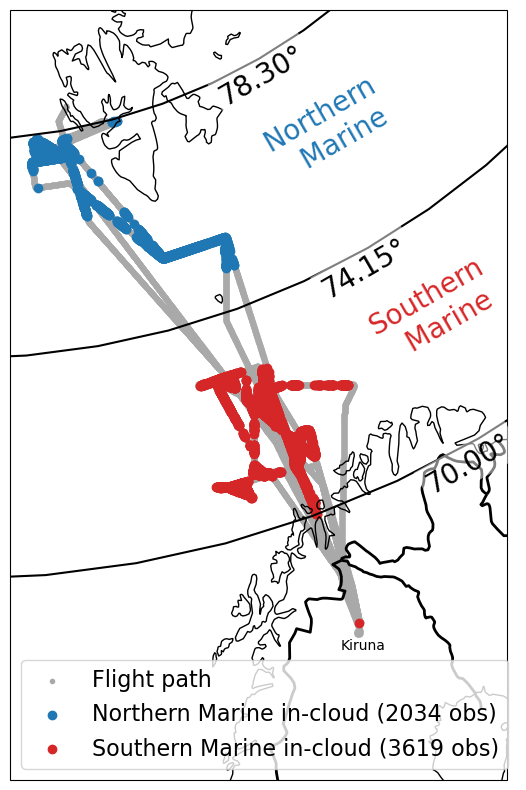

In [12]:
# --- Split for southern marine, northern marine and land datasets (in cloud)

# --- plotting division areas
# Define latitudes to set as boundaries
lat_min = ds_incloud.lat.values.min() # use ds-sea_lat to exclude the few sea datapoints too far south moving the division line too far south
lat_max = ds_incloud.lat.values.max()
lat_mid = lat_min + ((lat_max-lat_min)/2) # separation point for the southern marine and northern marine

# set lat-bands to compute between (as an array)
lat_bands = [lat_min, lat_mid, lat_max]

# Get the mask to use to select northern and southern band data
lat_mask_north, lat_mask_south,set_val_count_dict = plots.lat_2band_select(lat_bands, ds_incloud)

# set the value of region based on the two masks
ds_incloud['region'] = xr.where(lat_mask_north, 'north', xr.where(lat_mask_south, 'south', 'none'))

# drop values where region is 'none'
no_region_mask = (ds_incloud['region']=='none').compute()
ds_incloud = ds_incloud.where(~no_region_mask, drop=True)

# plot this variant of latitude bands:
#plot_text = f'In-cloud observations \n (tot. {len(ds_incloud.time)} obs.) per region' #\n \
           # Preselection: {pre_text}\n \
            #in-cloud threshold method: {th_method}, threshold(s): {th}'
savefile = save_path + f'{th_method}/Latitude_bands_regions_for_poster{th_method}{preopt}.png'
plot_lat_bands(lat_bands, ds, ds_incloud, '', savefile= savefile )

print(savefile)


## Plots

### Number concentration per region and per altitude band


In [13]:
# --- Prepwork for number concentration plots 3 bands

# separate out the different groups of data:
# - Northern marine
north_ds = ds_incloud.where(ds_incloud['region']=='north', drop = True)
# -- Get altitude layers: precip, base, bulk and top
# -- (optional: remove precip layer by adding precip = False in function)
# -- (optional: change number of layers in top and base by changing outer_layers, default = 2)
n_base_list,n_bulk_list,n_top_list,nalt_cats = functions.alt_cat_separator(north_ds, outer_layers = 1, precip = False)
# - Filter on altitude layers, and reduce the time dimension for the not-timedependent variables
north_top_ds = functions.reduce_to_bin_dim(north_ds.where(north_ds['altitude_bin'].isin(n_top_list), drop=True)) # Top layers
north_bulk_ds = functions.reduce_to_bin_dim(north_ds.where(north_ds['altitude_bin'].isin(n_bulk_list), drop=True)) # Bulk layers
north_base_ds = functions.reduce_to_bin_dim(north_ds.where(north_ds['altitude_bin'].isin(n_base_list), drop=True)) # Base layers
#north_precip_ds = functions.reduce_to_bin_dim(north_ds.where(north_ds['altitude_bin'].isin(n_precip_list), drop=True)) # Precip layer

# - Southern marine
south_ds = ds_incloud.where(ds_incloud['region']=='south', drop = True)
# -- Get altitude layers: precip, base, bulk and top
# -- (optional: add precip layer by adding precip = True in function (only using lowest layer as precip)
# -- (optional: change number of layers in top and base by changing outer_layers, default = 2)
s_base_list,s_bulk_list,s_top_list,s_alt_cats = functions.alt_cat_separator(south_ds, outer_layers = 1, precip=False)
# - Filter on altitude layers
south_top_ds = functions.reduce_to_bin_dim(south_ds.where(south_ds['altitude_bin'].isin(s_top_list), drop=True)) # Top layers
south_bulk_ds = functions.reduce_to_bin_dim(south_ds.where(south_ds['altitude_bin'].isin(s_bulk_list), drop=True)) # Bulk layers
south_base_ds = functions.reduce_to_bin_dim(south_ds.where(south_ds['altitude_bin'].isin(s_base_list), drop=True)) # Base layers
#south_precip_ds = functions.reduce_to_bin_dim(south_ds.where(south_ds['altitude_bin'].isin(s_precip_list), drop=True)) # Precip layer




Creating categories, without precip layer
Creating categories, without precip layer


In [14]:
print(ds_incloud.time.count().values)

print(south_top_ds.time.count().values)
print(south_bulk_ds.time.count().values)
print(north_bulk_ds.time.count().values)
print(north_top_ds.time.count().values)

print(south_top_ds.time.count().values+south_bulk_ds.time.count().values+north_bulk_ds.time.count().values+north_top_ds.time.count().values)

5653
281
3576
1854
24
5735


In [15]:
# --- Prepwork for number concentration plots 2 bands

# separate out the different groups of data:
# - Northern marine
north_ds = ds_incloud.where(ds_incloud['region']=='north', drop = True)
# -- Get altitude layers: precip, base, bulk and top
# -- (optional: remove precip layer by adding precip = False in function)
# -- (optional: change number of layers in top and base by changing outer_layers, default = 2)
n_bulk_list,n_top_list,nalt_cats = functions.alt_cat_separator(north_ds, outer_layers = 1, num_layer = 1, precip = False)
# - Filter on altitude layers, and reduce the time dimension for the not-timedependent variables
north_top_ds = functions.reduce_to_bin_dim(north_ds.where(north_ds['altitude_bin'].isin(n_top_list), drop=True)) # Top layers
north_bulk_ds = functions.reduce_to_bin_dim(north_ds.where(north_ds['altitude_bin'].isin(n_bulk_list), drop=True)) # Bulk layers
#north_base_ds = functions.reduce_to_bin_dim(north_ds.where(north_ds['altitude_bin'].isin(n_base_list), drop=True)) # Base layers
#north_precip_ds = functions.reduce_to_bin_dim(north_ds.where(north_ds['altitude_bin'].isin(n_precip_list), drop=True)) # Precip layer

# - Southern marine
south_ds = ds_incloud.where(ds_incloud['region']=='south', drop = True)
# -- Get altitude layers: precip, base, bulk and top
# -- (optional: add precip layer by adding precip = True in function (only using lowest layer as precip)
# -- (optional: change number of layers in top and base by changing outer_layers, default = 2)
s_bulk_list,s_top_list,s_alt_cats = functions.alt_cat_separator(south_ds, outer_layers = 1, num_layer = 1, precip=False)
# - Filter on altitude layers
south_top_ds = functions.reduce_to_bin_dim(south_ds.where(south_ds['altitude_bin'].isin(s_top_list), drop=True)) # Top layers
south_bulk_ds = functions.reduce_to_bin_dim(south_ds.where(south_ds['altitude_bin'].isin(s_bulk_list), drop=True)) # Bulk layers
#south_base_ds = functions.reduce_to_bin_dim(south_ds.where(south_ds['altitude_bin'].isin(s_base_list), drop=True)) # Base layers
#south_precip_ds = functions.reduce_to_bin_dim(south_ds.where(south_ds['altitude_bin'].isin(s_precip_list), drop=True)) # Precip layer




Creating categories, without precip layer
Creating categories, without precip layer


In [16]:
print(north_top_ds.time.max(), north_top_ds.time.min())

<xarray.DataArray 'time' ()> Size: 8B
array('2022-03-24T13:45:14.000000000', dtype='datetime64[ns]') <xarray.DataArray 'time' ()> Size: 8B
array('2022-03-24T10:46:19.000000000', dtype='datetime64[ns]')


In [17]:
# Create dataframe for visualizing available observations with Heatmap
# - number of observations per altitude bin vs latitude bin

# lat_bands: holds the division lines between lat bands: min, middle, max (floats) 
lat_bins = np.arange(math.floor(lat_bands[0]), math.ceil(lat_bands[2])+1) # array of 1 deg lats from 70 to 79 (ints) 

def create_counts(ds, lat_bins):
    grouped_data = ds['base_time'].groupby_bins('lat', bins=lat_bins) #group on lat binsbins
    
    count_data = grouped_data.map(lambda group: group.groupby('altitude_bin').count())
    
    # reorganize data before plotting heatmap
    # - turn into dataframe - unstack to get correct array structure  
    count_df = count_data.to_dataframe().unstack()
    
    # - transpose to get altitude on y-axis - reset index and drop outer index(base_time)
    count_df = count_df.T.reset_index(level=0, drop = True)
    # -  make sure all possible altitude bins are represented, fill with 0 - reverse order of altitudes
    count_df = count_df.reindex(bin_labels, fill_value=0).iloc[::-1] #
    count_df = count_df.fillna(0) # set nan to 0 (for easier plot management)
    count_df = count_df.astype(int) # set the count to int
    count_df = count_df.iloc[:, ::-1] # reverse the columns to get the northern most values to the left
    #fix labels 
    new_labels = [f"[{label.right}, {label.left})" for label in count_df.columns]
    count_df.columns = new_labels
    return count_df
    

count_df = create_counts(ds_incloud, lat_bins)
print(count_df)
count_rel_df = create_counts(ds_relevant, lat_bins)
print(count_rel_df)
#count_prec_df = create_counts(ds_precip, lat_bins)

# Calculating the percentage of total observations per category that is in cloud:

dist_df = ((count_df/count_rel_df)*100)

print(dist_df)

              [79, 78)  [78, 77)  [77, 76)  [76, 75)  [75, 74)  [74, 73)  \
altitude_bin                                                               
4350.0               0         0         0         0         0         0   
4050.0               0         0         0         0         0         0   
3750.0               0         0         0         0         0         0   
3450.0               0         0         0         0         0         0   
3150.0               0         0         0         0         0         0   
2850.0               0         0         0         0         0         0   
2550.0               0         0         0         0         0         0   
2250.0               0         0         0         0         0         0   
1950.0              15         6         3         0         0         0   
1650.0              14         9        40         0         0         2   
1350.0             169       138         6         0         0       113   
1050.0      

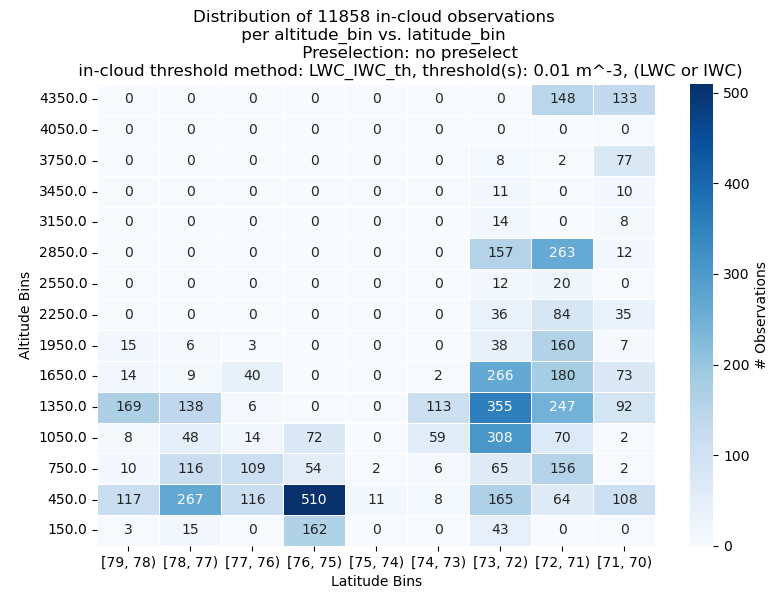

In [18]:
# heatplot of observations per altitude bin and latitude bin


# Creating the heatmap
#f, ax = plt.subplots(figsize=(9, 6))
#sns.heatmap(count_rel_df, annot=annotations.astype(str), fmt="", cmap='Blues', ax=ax, 
#            mask=mask, cbar_kws={"label": "# Observations"},
#            linewidths=0.5)

# Mask for annotations: `True` where data is 0, not just NaN
mask = (count_df == -99.9)
tot_count = count_rel_df.values.sum()
#tot_count =len(ds_incloud['base_time']) what I had before

# Prepare annotations, providing fallback for zeros
annotations = count_df.where(~mask, other='')

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(count_df, annot=annotations, fmt="", cmap='Blues', ax=ax, 
            mask=mask, cbar_kws={"label": "# Observations"},
            linewidths=0.5)

plt.xlabel('Latitude Bins')
plt.ylabel('Altitude Bins')
plt.title(f'Distribution of {tot_count} in-cloud observations \n per altitude_bin vs. latitude_bin  \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}')
plt.savefig(save_path + f'{th_method}/incloud_obs_per_alt_lat_{th_method}{preopt}.png')


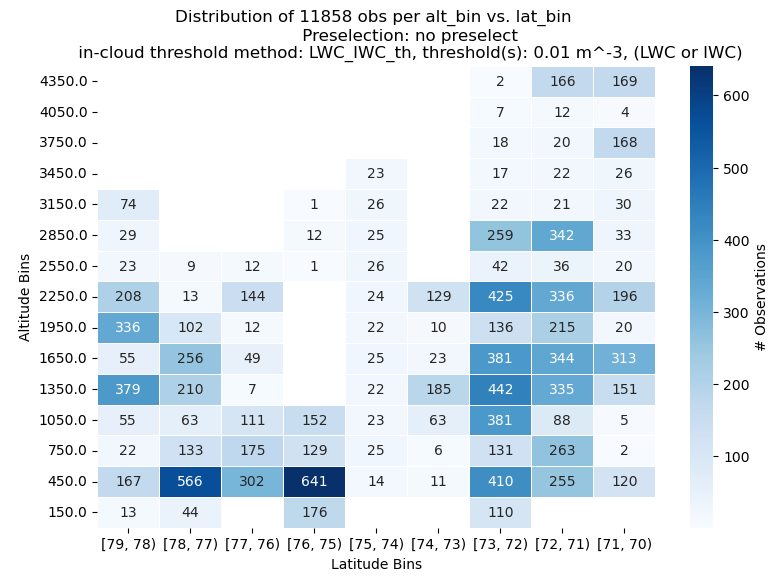

In [19]:
# heatplot of observations per altitude bin and latitude bin: relevant


# Mask for annotations: `True` where data is 0, not just NaN
mask = (count_rel_df == 0)
tot_count = count_rel_df.values.sum()

# Prepare annotations: Show counts as strings only for non-zero values
annotations = count_rel_df.astype(str)
annotations[mask] = ''  # Replace zeros with empty strings for annotations

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(count_rel_df, annot=annotations, fmt="",cmap='Blues', ax=ax, 
            mask=mask, cbar_kws={"label": "# Observations"},
            linewidths=0.5)

plt.xlabel('Latitude Bins')
plt.ylabel('Altitude Bins')
plt.title(f'Distribution of {tot_count} obs per alt_bin vs. lat_bin \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}')
plt.savefig(save_path + f'{th_method}/observ_per_alt_lat_{th_method}{preopt}.png')


In [20]:
#count_df
#dist_df
count_rel_df

[79, 78)  [78, 77)  [77, 76)  [76, 75)  [75, 74)  [74, 73)  \
altitude_bin                                                               
4350.0               0         0         0         0         0         0   
4050.0               0         0         0         0         0         0   
3750.0               0         0         0         0         0         0   
3450.0               0         0         0         0        23         0   
3150.0              74         0         0         1        26         0   
2850.0              29         0         0        12        25         0   
2550.0              23         9        12         1        26         0   
2250.0             208        13       144         0        24       129   
1950.0             336       102        12         0        22        10   
1650.0              55       256        49         0        25        23   
1350.0             379       210         7         0        22       185   
1050.0              55        63       111       152        23        63   
750.0               22       133       175       129        25         6   
450.0              167       566       302       641        14        11   
150.0               13        44         0       176         0         0   

              [73, 72)  [72, 71)  [71, 70)  
altitude_bin                                
4350.0               2       166       169  
4050.0               7        12         4  
3750.0              18        20       168  
3450.0              17        22        26  
3150.0              22        21        30  
2850.0             259       342        33  
2550.0              42        36        20  
2250.0             425       336       196  
1950.0             136       215        20  
1650.0             381       344       313  
1350.0             442       335       151  
1050.0             381        88         5  
750.0              131       263         2  
450.0              410       255       120  
150.0              110         0         0

Latitudebands/Alldata/LWC_IWC_th/Perc_incloud_alt_lat_LWC_IWC_th.png


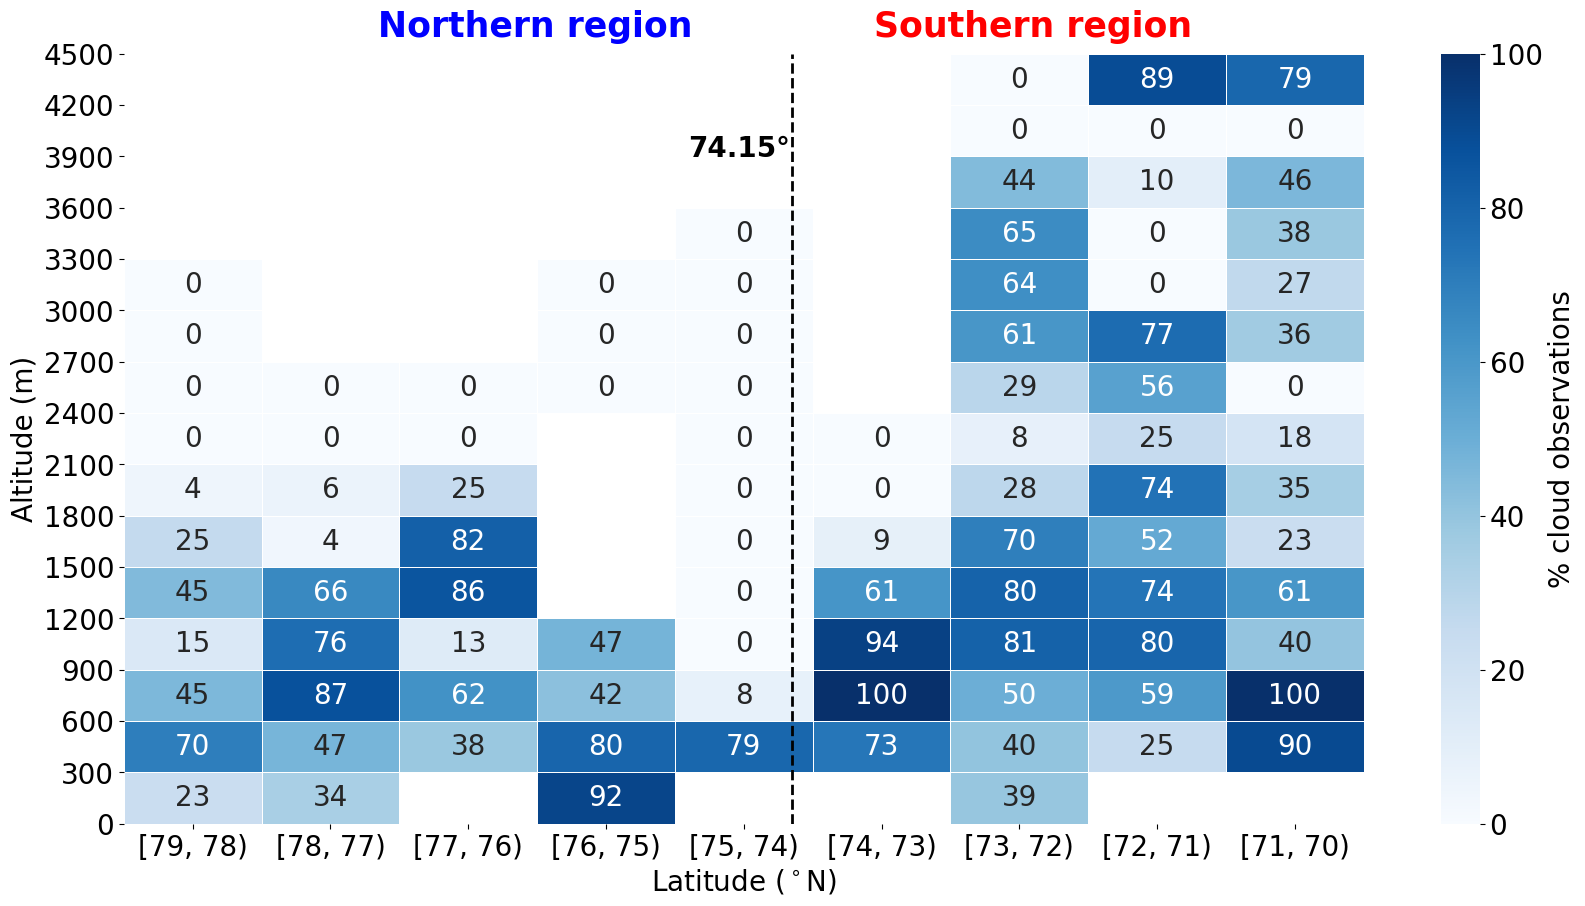

In [21]:
# heatplot of percentage of observations that where in-cloud
f, ax = plt.subplots(figsize=(20, 10))

#plot text size options
hs=25
ss=20

pl = sns.heatmap(dist_df, annot=True, fmt=".0f", cmap='Blues', ax=ax, 
            cbar_kws={"label": "% cloud observations"},
            linewidths=0.5, annot_kws={'size':ss}, vmin=0)

pl.set_xlabel('Latitude ($^\circ$N)',fontsize=ss)
pl.set_ylabel('Altitude (m)', fontsize=ss)
pl.axes.get_yaxis().set_visible(False) # only show x-axis, the other plot shows the y-axis

# colorbar options
cbar = pl.collections[0].colorbar  # Get the colorbar from the heatmap
cbar.ax.tick_params(labelsize=ss)  # Change the size of the colorbar ticks
cbar.set_label('% cloud observations', fontsize=ss)  # Change colorbar label size

# ticklabel adjustments
xlab = pl.get_xticklabels() 
pl.set_xticklabels(labels = xlab, size=ss)
ylab = pl.get_yticklabels()
for label in ylab:
    label.set_text(label.get_text().replace('.0', '')) # remove all '.0'
pl.set_yticklabels(labels = ylab, size = ss, rotation=45)

# add overlines
# Create overlay plot
ax_lines = f.add_axes(ax.get_position(), frameon=False)
ax_lines.set_xlim(79,70)
ax_lines.set_ylim(0,4500)
yticks = np.linspace (0,4500,300)
ax_lines.set_yticks(altitude_bins)
ax_lines.axes.get_xaxis().set_visible(False) # only show the y-axis, the other plot shows the xaxis (this shows the altitudes better.)
ax_lines.set_ylabel('Altitude (m)', fontsize=ss)
ax_lines.tick_params(labelsize=ss)


# Plot the limit between the two regions
ax_lines.axvline(lat_bands[1], ls='--', c='k', lw=2)
ax_lines.text(lat_bands[1] + 3, 4600, 'Northern region', c='b', weight='bold', fontsize=hs)
ax_lines.text(lat_bands[1] - 0.6, 4600, 'Southern region', c='r', weight='bold', fontsize=hs)
ax_lines.text(lat_bands[1] + 0.75, 3900, f"{lat_bands[1]:.2f}°", weight='bold',c='k', fontsize=ss)

#plt.title(f'Percentage of in cloud observations per total obs per alt_bin vs. lat_bin \n \
#            Preselection: {pre_text}\n \
#            in-cloud threshold method: {th_method}, threshold(s): {th}')
#plt.title(f'Percentage of in cloud observations \n per total obs per alt_bin vs. lat_bin', fontsize=20)
plt.savefig(save_path + f'{th_method}/Perc_incloud_alt_lat_{th_method}{preopt}.png')

print(save_path + f'{th_method}/Perc_incloud_alt_lat_{th_method}{preopt}.png')

In [22]:
ylab = pl.get_yticklabels()
# Remove '.0' from the text labels
for label in ylab:
    label.set_text(label.get_text().replace('.0', ''))

ylab# Remove '.0' from the text labels
for label in ylab:
    label.set_text(label.get_text().replace('.0', ''))

NameError: name 'div_loc' is not defined

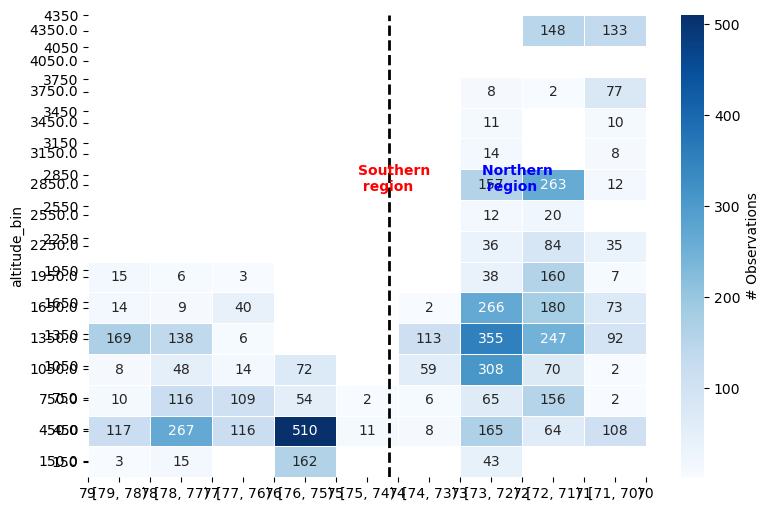

In [23]:
# Combined heatplot and altitude/region lines

import seaborn as sns

# Mask for annotations: `True` where data is 0, not just NaN
mask = (count_df == 0)

f, ax = plt.subplots(figsize=(9, 6))
hm = sns.heatmap(count_df, annot=True, fmt="d", cmap='Blues', ax=ax, 
            mask=mask, cbar_kws={"label": "# Observations"},
            linewidths=0.5)
# Create overlay plot
ax_lines = f.add_axes(ax.get_position(), frameon=False)
ax_lines.set_xlim(79,70)
ax_lines.set_ylim(0,3000)
ax_lines.set_yticks(bin_labels)

#div_loc = (lat_bands[1] - 70) / (79 - 70)

# Plot the limit between the two regions
ax_lines.axvline(lat_bands[1], ls='--', c='k', lw=2)
ax_lines.text(lat_bands[1] - 1.5, 2700, 'Northern \n region', c='b', weight='bold')
ax_lines.text(lat_bands[1] + 0.5, 2700, 'Southern \n region', c='r', weight='bold')

# Northern marine
ax_lines.axhline(north_ds['alt'].max().values, 0,div_loc, ls='--', c='b', lw=2, alpha=0.3)
ax_lines.text(70.05,north_ds['alt'].max().values+60,f'max: {int(north_ds['alt'].max().values)} m',c='b',alpha=0.3)
ax_lines.axhline(north_ds['alt'].min().values, 0, div_loc, ls='--', c='b', lw=2, alpha=0.3)
ax_lines.text(70.05,north_ds['alt'].min().values-100,f'min: {int(north_ds['alt'].min().values)} m',c='b',alpha=0.3)

#precip_l = n_precip_list[0] + 150
#ax_lines.axhline(precip_l, div_loc, 1, ls='--', c='b', lw=2, alpha=0.3)
#ax_lines.text(78, n_precip_list[0], 'Precip', c='b', alpha=0.3)

base_l = n_base_list[0] + 150
ax_lines.axhline(base_l, 0, div_loc, ls='--', c='b', lw=2, alpha=0.3)
ax_lines.text(70.05, n_base_list[0]+150, 'Base', c='b', alpha=0.3)

bulk_l = n_bulk_list[-1] + 150
ax_lines.axhline(bulk_l, 0, div_loc, ls='--', c='b', lw=2, alpha=0.3)
ax_lines.text(70.05, n_bulk_list[-1], 'Bulk', c='b', alpha=0.3)
ax_lines.text(70.05, n_top_list[0], 'Top', c='b', alpha=0.3)

# Southern marine
ax_lines.axhline(south_ds['alt'].max().values,div_loc, 1, ls='--', c='r', lw=2, alpha=0.3) # highest altitude in south_ds
ax_lines.text(78,south_ds['alt'].max().values+60,f'max: {int(south_ds['alt'].max().values)} m', c='r', alpha=0.3)
ax_lines.axhline(south_ds['alt'].min().values,div_loc,1,ls='--', c='r', lw=2, alpha=0.3) # lowest altitude in south_ds
ax_lines.text(78,south_ds['alt'].min().values-100,f'min: {int(south_ds['alt'].min().values)} m', c='r', alpha=0.3)

#precip_l = s_precip_list[0]+150 # Precip upper edge (the one layer and + 150 to get the upper edge)
#ax_lines.axhline(precip_l,0,div_loc,ls='--', c='r', lw=2, alpha=0.3)
#ax_lines.text(73.2,s_precip_list[0],'Precip', c='r', alpha=0.3)

base_l = s_base_list[0]+150 # base upper edge
ax_lines.axhline(base_l,div_loc,1,ls='--', c='r', lw=2, alpha=0.3)
ax_lines.text(78,s_base_list[0]+150,'Base', c='r', alpha=0.3)

bulk_l = s_bulk_list[-1]+150 # bulk upper edge
ax_lines.axhline(bulk_l,div_loc,1,ls='--', c='r', lw=2, alpha=0.3)
ax_lines.text(78,s_bulk_list[-1],'Bulk', c='r', alpha=0.3)
ax_lines.axhline(bulk_l,div_loc,1,ls='--', c='r', lw=2, alpha=0.3)
ax_lines.text(78,s_top_list[0],'Top', c='r', alpha=0.3)

# Hide overlay axes labels
ax_lines.set_xticks([])
ax_lines.set_yticks([])
ax_lines.set_xlabel('')

ax.set_xlabel('Latitude Bins')
ax.set_ylabel('Altitude Bins')

plt.title(f'Distribution of {tot_count} observations per alt_bin vs. lat_bin \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}')

plt.savefig(save_path + f'{th_method}/Obs_dist_region_alt_lat_{th_method}{preopt}.png')



In [24]:
print(north_top_ds.time.values.max(),north_top_ds.time.values.min())
print(south_top_ds.time.values.max(),south_top_ds.time.values.min())

2022-03-24T13:45:14.000000000 2022-03-24T10:46:19.000000000
2022-03-22T14:29:56.000000000 2022-03-22T14:02:16.000000000


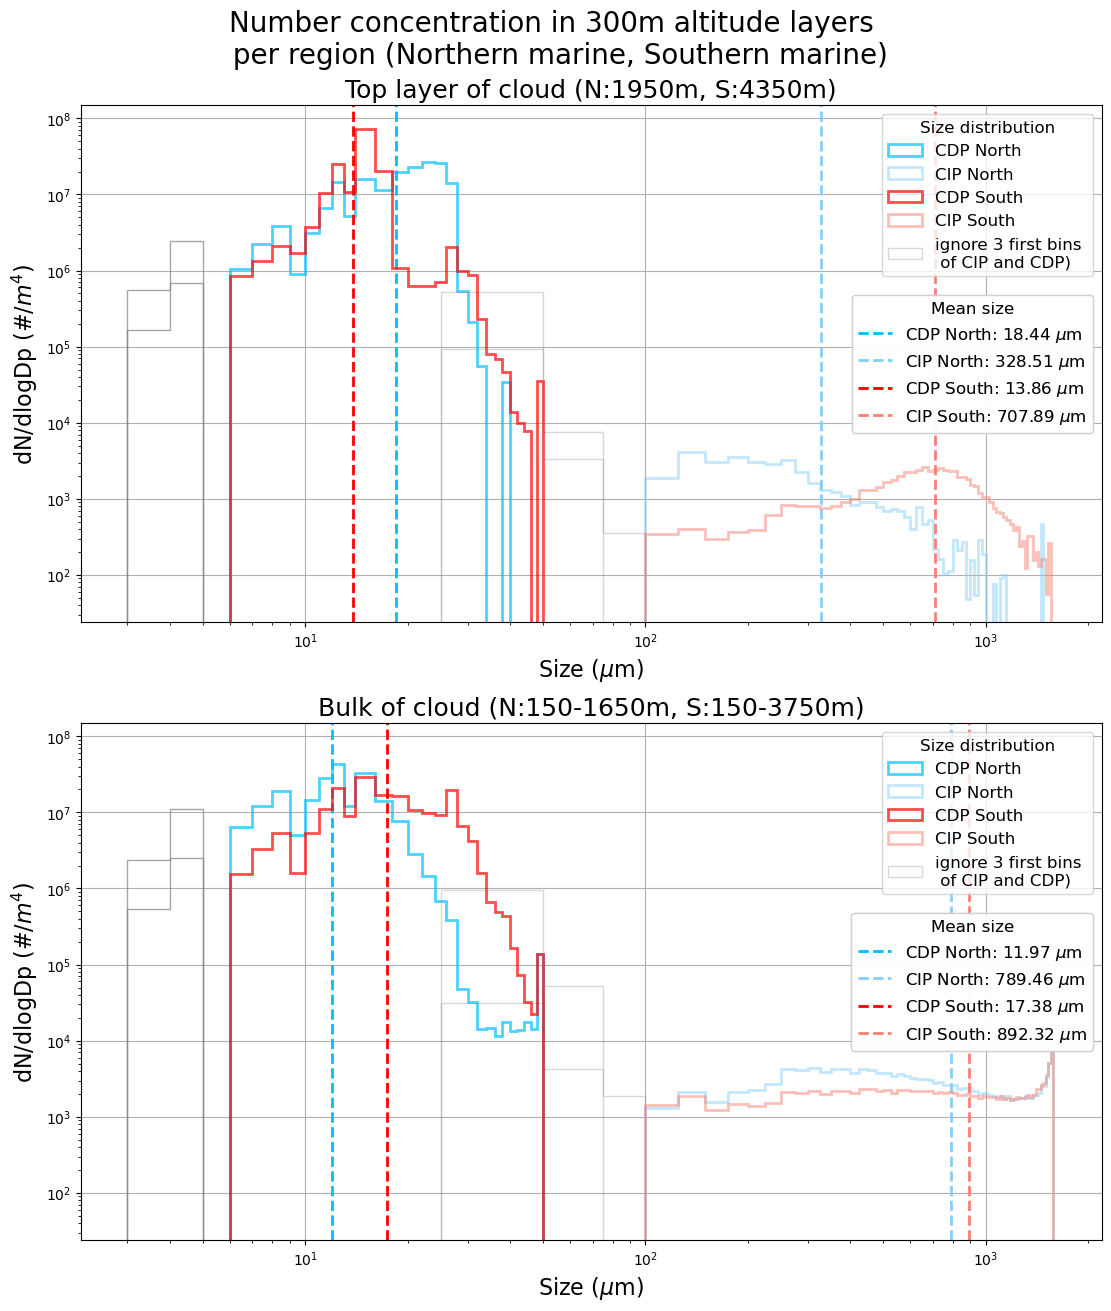

In [25]:
##### --- Plotting number concentrations in same plot (top and bulk)
### removing the values of cip that is below 6 um

fig, ax = plt.subplots(2, 1, figsize=(11, 13), layout="constrained", sharey=True)

def numb_conc_plot_same(ax, ds_n, ds_s, cat_text):
    import matplotlib as plt
    import numb_conc # number concentration functions
    from scipy.stats import gamma
    import numpy as np

    #handles and labels for legends
    h_hist = []
    l_hist = []
    
    # Get the normalized values for plotting (from functions in numb_conc)
    n_cip_part_norm = numb_conc.cip_mean_norm_Nt(ds_n)
    n_cdp_part_norm = numb_conc.cdp_mean_norm_Nt(ds_n)
    s_cip_part_norm = numb_conc.cip_mean_norm_Nt(ds_s)
    s_cdp_part_norm = numb_conc.cdp_mean_norm_Nt(ds_s)

    # plot histogram based on normalized data and binning size information for CDP and CIP
    # North
    # exclude the 4 first bins of cdp (lower than 6 microns)
    h0  = ax.hist(ds_n['Size'].values[:3], weights = n_cdp_part_norm.values[:3], bins=ds_n['Size'].values[:3], label = "CDP north", 
            histtype='step', alpha = 0.7, color='grey')
    h1  = ax.hist(ds_n['Size'].values[3:], weights = n_cdp_part_norm.values[3:], bins=ds_n['Size'].values[3:], label = "CDP north", 
            histtype='step', alpha = 0.7, linewidth = 2, color='deepskyblue')
    
    h_hist.append(h1[2][0])
    l_hist.append('CDP North')
    
    midbins = ds_n['MIDBINS'].values
    weights = n_cip_part_norm.values
    h2 = ax.hist(midbins[:3], weights=weights[:3], bins=midbins[:3], label="CIP North", color='grey', histtype='step', alpha=0.3)# Plot first three bins in grey
    h3 = ax.hist(midbins[3:], weights=weights[3:], bins=midbins[3:], label="CIP North", color='lightskyblue', linewidth = 2, histtype='step', alpha = 0.5)
    h_hist.append(h3[2][0])
    l_hist.append('CIP North')
    
    # --- calculate mean number concentration from the histogram 
    # - CDP
    prod_val_count_cdp = ds_n['Size'].values*n_cdp_part_norm.values
    tot_sum = prod_val_count_cdp[3:].sum()
    counts= n_cdp_part_norm.values[3:]
    count_sum = counts.sum()
    mean_size_cdp = tot_sum/count_sum
    # set as vertical line in plot
    l1 = ax.axvline(mean_size_cdp, color='deepskyblue', linestyle='dashed', linewidth=2, label=f'CDP North: {mean_size_cdp:.2f} $\mu$m')
    
    # - CIP
    # Only calculate the mean on the bins that are not greyed out (the first 3 bins)
    prod_val_count_cip = n_cip_part_norm.values*ds_n['MIDBINS'].values
    tot_sum = prod_val_count_cip[3:].sum()
    count_sum = n_cip_part_norm.values[3:].sum()
    mean_size_cip = tot_sum/count_sum
    # set as vertical line in plot
    l2 = ax.axvline(mean_size_cip, color='lightskyblue', linestyle='dashed', linewidth=2, label=f'CIP North: {mean_size_cip:.2f} $\mu$m')

    # South
    h4 = ax.hist(ds_s['Size'].values[3:], weights = s_cdp_part_norm.values[3:], bins=ds_s['Size'].values[3:], label = "CDP South", 
            histtype='step', alpha = 0.7,linewidth = 2, color = 'red')
    h7 = ax.hist(ds_s['Size'].values[:3], weights = s_cdp_part_norm.values[:3], bins=ds_s['Size'].values[:3], label = "CDP South", 
            histtype='step', alpha = 0.7, color = 'grey')
    h_hist.append(h4[2][0])
    l_hist.append('CDP South')
    
    midbins = ds_s['MIDBINS'].values
    weights = s_cip_part_norm.values
    h5 = ax.hist(midbins[:3], weights=weights[:3], bins=midbins[:4], label="CIP South", color='grey', histtype='step', alpha=0.3)# Plot first three bins in grey
    h6 = ax.hist(midbins[3:], weights=weights[3:], bins=midbins[3:], label="CIP South", color = 'salmon', linewidth = 2, histtype='step', alpha = 0.5)
    h_hist.append(h6[2][0])
    l_hist.append('CIP South')
    h_hist.append(h5[2][0])
    l_hist.append('ignore 3 first bins \n of CIP and CDP)')
    
    # --- calculate mean number concentration from the histogram
    # - CDP
    prod_val_count_cdp = ds_s['Size'].values*s_cdp_part_norm.values
    tot_sum = prod_val_count_cdp[3:].sum()
    counts= s_cdp_part_norm.values[3:]
    count_sum = counts.sum()
    mean_size_cdp = tot_sum/count_sum
    # set as vertical line in plot
    l3 = ax.axvline(mean_size_cdp, color='red', linestyle='dashed', linewidth=2, label=f'CDP South: {mean_size_cdp:.2f} $\mu$m')
    
    # - CIP
    # Only calculate the mean on the bins that are not greyed out (the first 3 bins)
    prod_val_count_cip = s_cip_part_norm.values*ds_s['MIDBINS'].values
    tot_sum = prod_val_count_cip[3:].sum()
    count_sum = s_cip_part_norm.values[3:].sum()
    mean_size_cip = tot_sum/count_sum
    # set as vertical line in plot
    l4 = ax.axvline(mean_size_cip, color='salmon', linestyle='dashed', linewidth=2, label=f'CIP South: {mean_size_cip:.2f} $\mu$m')
   
    
    # set labels, titles and legends for subplots
    ax.set_ylabel('dN/dlogDp (#/$m^4$)', fontsize=16)
    ax.set_xlabel('Size ($\mu$m)',fontsize = 16)
    ax.set_title(cat_text, fontsize=18)

    # first legend:
    legend1 = ax.legend(handles=h_hist,labels = l_hist, loc='upper right', title='Size distribution', fontsize = 12, title_fontsize=12)
    ax.add_artist(legend1)

    #second legend:
    legend2 = ax.legend(handles=[l1,l2,l3,l4], loc = 'center right', title='Mean size', fontsize = 12,title_fontsize=12)
    ax.add_artist(legend2)

# Top layer
numb_conc_plot_same(ax[0], north_top_ds, south_top_ds, f'Top layer of cloud (N:{n_top_list[0]}m, S:{s_top_list[0]}m)')

# Bulk layers
numb_conc_plot_same(ax[1], north_bulk_ds, south_bulk_ds, f'Bulk of cloud (N:{n_bulk_list[0]}-{n_bulk_list[-1]}m, S:{s_bulk_list[0]}-{s_bulk_list[-1]}m)')


# --- Subplot settings
for ax in ax.ravel():  # Flatten the array of axes and iterate
    ax.set_xscale('log')  # Set x-axis to log scale
    ax.set_yscale('log')  # Set y-axis to log scale
    ax.grid(True)
    #ax.label_outer()  # This method hides only labels in the inner axes; keep it commented out to show labels
    ax.yaxis.set_tick_params(which='both', labelleft=True)
    ax.xaxis.set_tick_params(which='both', labelbottom=True)

# --- Figure 
#plt.suptitle(f'Number concentration in 300m altitude layers per region (North marine, South marine) \n \
#            Pre-selection: {pre_text}\n \
#            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.suptitle(f'Number concentration in 300m altitude layers \n per region (Northern marine, Southern marine)', fontsize=20)
plt.savefig(save_path+f'{th_method}/Ntjoint_Latitude_bands_2layer_rem3bins{th_method}{preopt}.png') # Save to
plt.show()


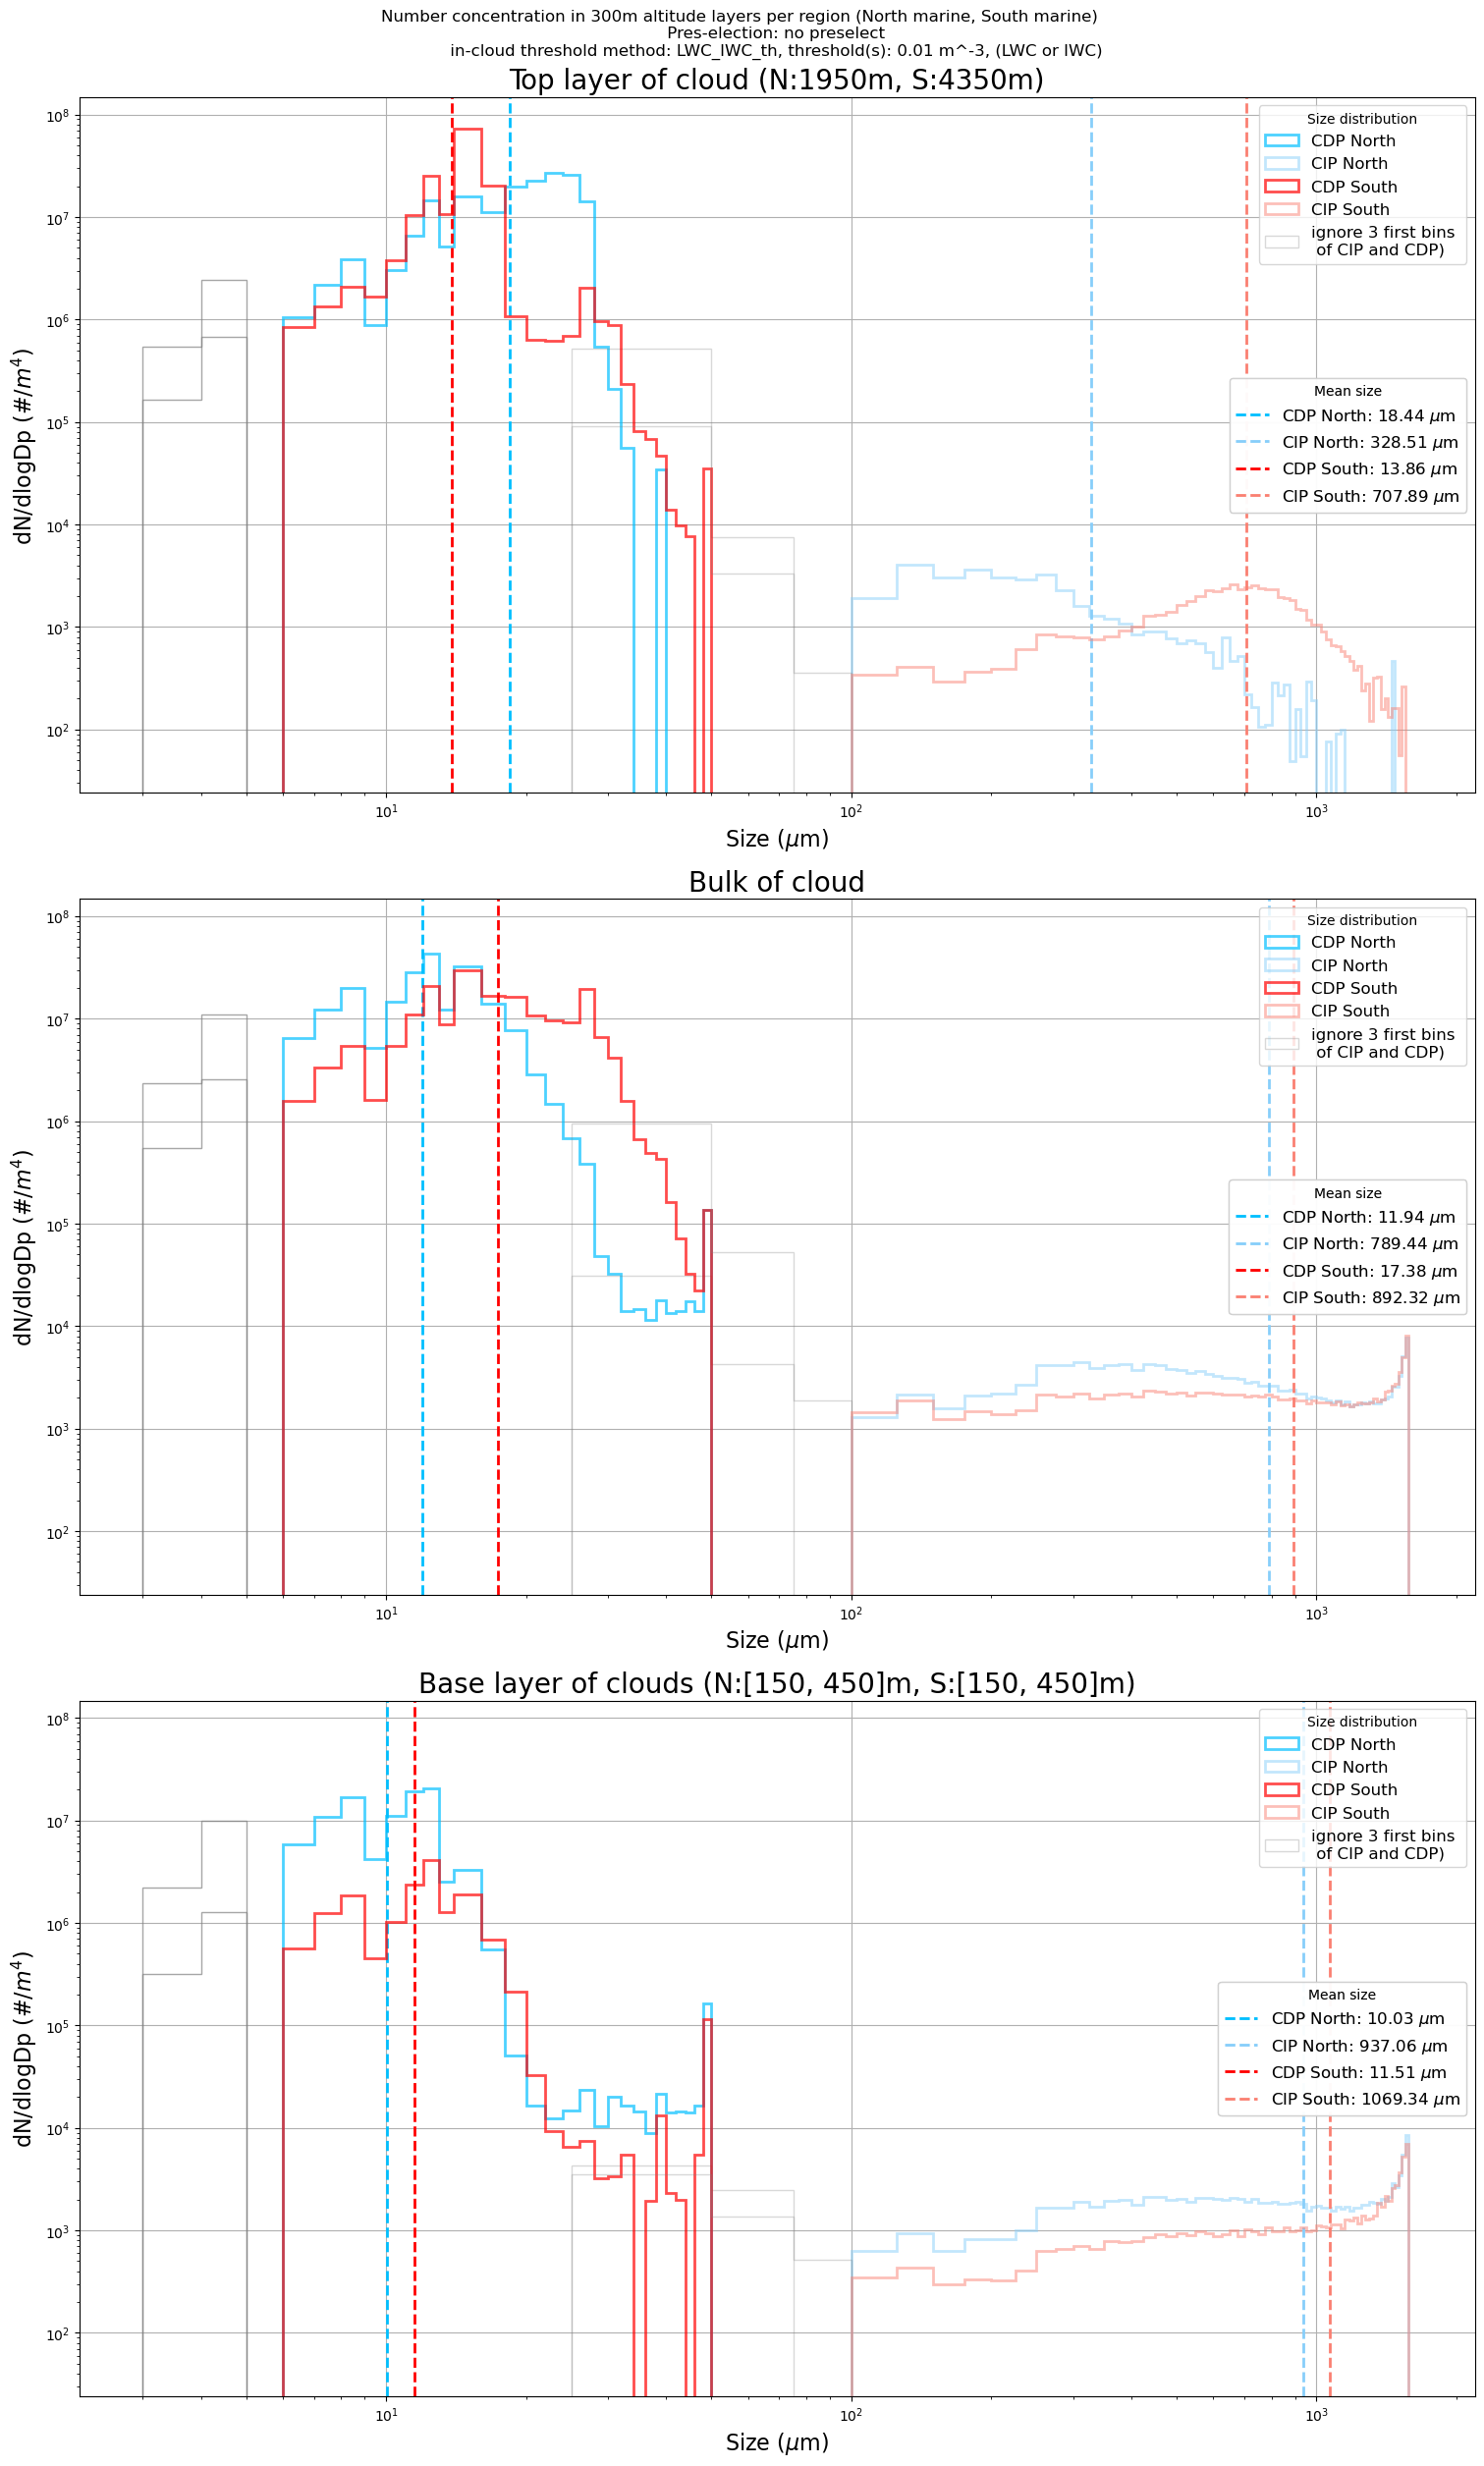

In [22]:
##### --- Plotting number concentrations in same plot
### removing the values of cip that is below 6 um

fig, ax = plt.subplots(3, 1, figsize=(15, 25), layout="constrained", sharey=True)

# Northern Marine, Top Layer

def numb_conc_plot_same(ax, ds_n, ds_s, cat_text):
    import matplotlib as plt
    import numb_conc # number concentration functions
    from scipy.stats import gamma
    import numpy as np

    #handles and labels for legends
    h_hist = []
    l_hist = []
    
    # Get the normalized values for plotting (from functions in numb_conc)
    n_cip_part_norm = numb_conc.cip_mean_norm_Nt(ds_n)
    n_cdp_part_norm = numb_conc.cdp_mean_norm_Nt(ds_n)
    s_cip_part_norm = numb_conc.cip_mean_norm_Nt(ds_s)
    s_cdp_part_norm = numb_conc.cdp_mean_norm_Nt(ds_s)

    # plot histogram based on normalized data and binning size information for CDP and CIP
    # North
    # exclude the 4 first bins of cdp (lower than 6 microns)
    h0  = ax.hist(ds_n['Size'].values[:3], weights = n_cdp_part_norm.values[:3], bins=ds_n['Size'].values[:3], label = "CDP north", 
            histtype='step', alpha = 0.7, color='grey')
    h1  = ax.hist(ds_n['Size'].values[3:], weights = n_cdp_part_norm.values[3:], bins=ds_n['Size'].values[3:], label = "CDP north", 
            histtype='step', alpha = 0.7, linewidth = 2, color='deepskyblue')
    
    h_hist.append(h1[2][0])
    l_hist.append('CDP North')
    
    midbins = ds_n['MIDBINS'].values
    weights = n_cip_part_norm.values
    h2 = ax.hist(midbins[:3], weights=weights[:3], bins=midbins[:3], label="CIP North", color='grey', histtype='step', alpha=0.3)# Plot first three bins in grey
    h3 = ax.hist(midbins[3:], weights=weights[3:], bins=midbins[3:], label="CIP North", color='lightskyblue', linewidth = 2, histtype='step', alpha = 0.5)
    h_hist.append(h3[2][0])
    l_hist.append('CIP North')
    
    # --- calculate mean number concentration from the histogram 
    # - CDP
    prod_val_count_cdp = ds_n['Size'].values*n_cdp_part_norm.values
    tot_sum = prod_val_count_cdp[3:].sum()
    counts= n_cdp_part_norm.values[3:]
    count_sum = counts.sum()
    mean_size_cdp = tot_sum/count_sum
    # set as vertical line in plot
    l1 = ax.axvline(mean_size_cdp, color='deepskyblue', linestyle='dashed', linewidth=2, label=f'CDP North: {mean_size_cdp:.2f} $\mu$m')
    
    # - CIP
    # Only calculate the mean on the bins that are not greyed out (the first 3 bins)
    prod_val_count_cip = n_cip_part_norm.values*ds_n['MIDBINS'].values
    tot_sum = prod_val_count_cip[3:].sum()
    count_sum = n_cip_part_norm.values[3:].sum()
    mean_size_cip = tot_sum/count_sum
    # set as vertical line in plot
    l2 = ax.axvline(mean_size_cip, color='lightskyblue', linestyle='dashed', linewidth=2, label=f'CIP North: {mean_size_cip:.2f} $\mu$m')

    # South
    h4 = ax.hist(ds_s['Size'].values[3:], weights = s_cdp_part_norm.values[3:], bins=ds_s['Size'].values[3:], label = "CDP South", 
            histtype='step', alpha = 0.7,linewidth = 2, color = 'red')
    h7 = ax.hist(ds_s['Size'].values[:3], weights = s_cdp_part_norm.values[:3], bins=ds_s['Size'].values[:3], label = "CDP South", 
            histtype='step', alpha = 0.7, color = 'grey')
    h_hist.append(h4[2][0])
    l_hist.append('CDP South')
    
    midbins = ds_s['MIDBINS'].values
    weights = s_cip_part_norm.values
    h5 = ax.hist(midbins[:3], weights=weights[:3], bins=midbins[:4], label="CIP South", color='grey', histtype='step', alpha=0.3)# Plot first three bins in grey
    h6 = ax.hist(midbins[3:], weights=weights[3:], bins=midbins[3:], label="CIP South", color = 'salmon', linewidth = 2, histtype='step', alpha = 0.5)
    h_hist.append(h6[2][0])
    l_hist.append('CIP South')
    h_hist.append(h5[2][0])
    l_hist.append('ignore 3 first bins \n of CIP and CDP)')
    
    # --- calculate mean number concentration from the histogram
    # - CDP
    prod_val_count_cdp = ds_s['Size'].values*s_cdp_part_norm.values
    tot_sum = prod_val_count_cdp[3:].sum()
    counts= s_cdp_part_norm.values[3:]
    count_sum = counts.sum()
    mean_size_cdp = tot_sum/count_sum
    # set as vertical line in plot
    l3 = ax.axvline(mean_size_cdp, color='red', linestyle='dashed', linewidth=2, label=f'CDP South: {mean_size_cdp:.2f} $\mu$m')
    
    # - CIP
    # Only calculate the mean on the bins that are not greyed out (the first 3 bins)
    prod_val_count_cip = s_cip_part_norm.values*ds_s['MIDBINS'].values
    tot_sum = prod_val_count_cip[3:].sum()
    count_sum = s_cip_part_norm.values[3:].sum()
    mean_size_cip = tot_sum/count_sum
    # set as vertical line in plot
    l4 = ax.axvline(mean_size_cip, color='salmon', linestyle='dashed', linewidth=2, label=f'CIP South: {mean_size_cip:.2f} $\mu$m')
   
    
    # set labels, titles and legends for subplots
    ax.set_ylabel('dN/dlogDp (#/$m^4$)', fontsize = 16)
    ax.set_xlabel('Size ($\mu$m)', fontsize = 16)
    ax.set_title(cat_text, fontsize=20)

    # first legend:
    legend1 = ax.legend(handles=h_hist,labels = l_hist, loc='upper right', title='Size distribution', fontsize = 12)
    ax.add_artist(legend1)

    #second legend:
    legend2 = ax.legend(handles=[l1,l2,l3,l4], loc = 'center right', title='Mean size', fontsize = 12)
    ax.add_artist(legend2)

# Top layer
numb_conc_plot_same(ax[0], north_top_ds, south_top_ds, f'Top layer of cloud (N:{n_top_list[0]}m, S:{s_top_list[0]}m)')

# Bulk layers
numb_conc_plot_same(ax[1], north_bulk_ds, south_bulk_ds, f'Bulk of cloud')

# Base layers
numb_conc_plot_same(ax[2], north_base_ds, south_base_ds, f'Base layer of clouds (N:{n_base_list}m, S:{s_base_list}m)')

# --- Subplot settings
for ax in ax.ravel():  # Flatten the array of axes and iterate,
    ax.set_xscale('log')  # Set x-axis to log scale
    ax.set_yscale('log')  # Set y-axis to log scale
    ax.grid(True)
    #ax.label_outer()  # This method hides only labels in the inner axes; keep it commented out to show labels
    ax.yaxis.set_tick_params(which='both', labelleft=True)
    ax.xaxis.set_tick_params(which='both', labelbottom=True)

# --- Figure 
plt.suptitle(f'Number concentration in 300m altitude layers per region (North marine, South marine) \n \
            Pres-election: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/Ntjoint_Latitude_bands_2base_rem3bins{th_method}{preopt}.png') # Save to
plt.show()


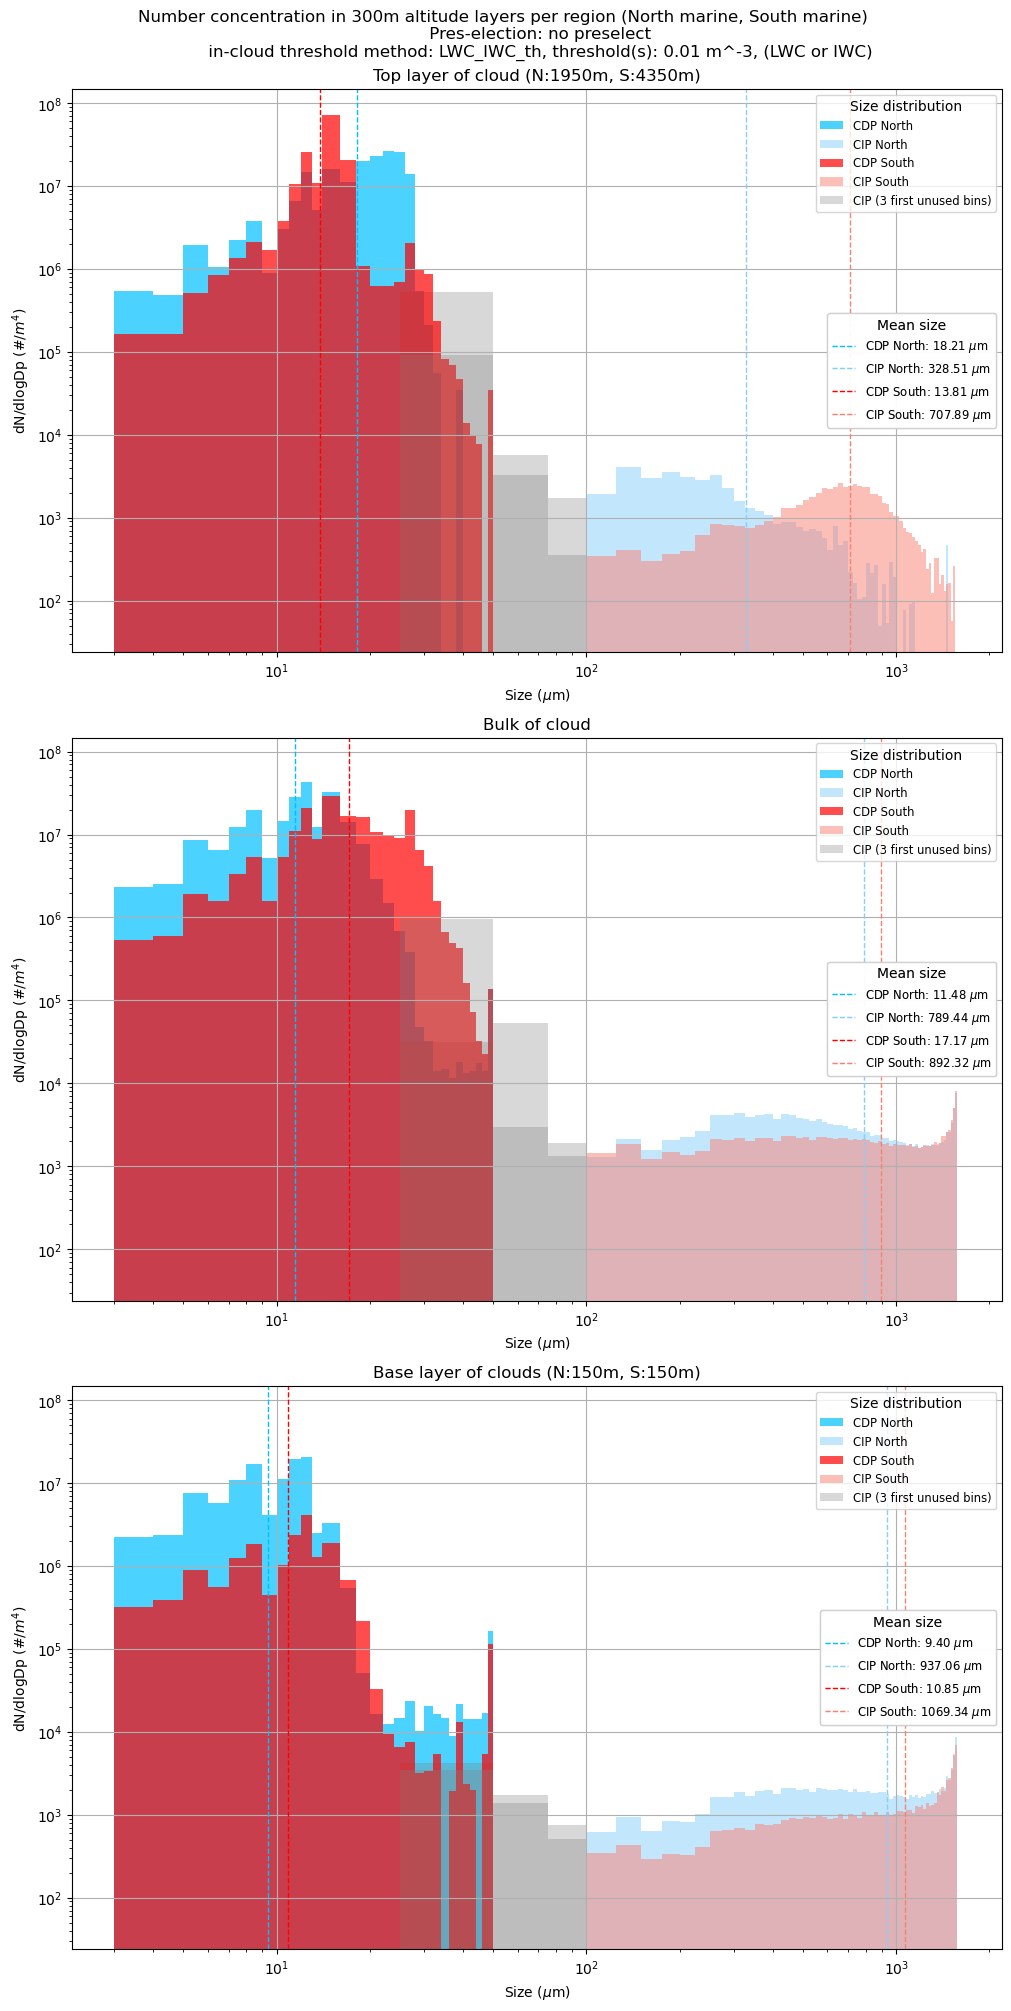

In [23]:
##### --- Plotting number concentrations in same plot
fig, ax = plt.subplots(3, 1, figsize=(10, 20), layout="constrained", sharey=True)

# Northern Marine, Top Layer

def numb_conc_plot_same(ax, ds_n, ds_s, cat_text):
    import matplotlib as plt
    import numb_conc # number concentration functions
    from scipy.stats import gamma
    import numpy as np

    #handles and labels for legends
    h_hist = []
    l_hist = []
    
    # Get the normalized values for plotting (from functions in numb_conc)
    n_cip_part_norm = numb_conc.cip_mean_norm_Nt(ds_n)
    n_cdp_part_norm = numb_conc.cdp_mean_norm_Nt(ds_n)
    s_cip_part_norm = numb_conc.cip_mean_norm_Nt(ds_s)
    s_cdp_part_norm = numb_conc.cdp_mean_norm_Nt(ds_s)


    # plot histogram based on normalized data and binning size information for CDP and CIP
    # North
    h1  = ax.hist(ds_n['Size'].values, weights = n_cdp_part_norm.values, bins=ds_n['Size'].values, label = "CDP north", 
            histtype='stepfilled', alpha = 0.7, color='deepskyblue')
    h_hist.append(h1[2][0])
    l_hist.append('CDP North')
    
    midbins = ds_n['MIDBINS'].values
    weights = n_cip_part_norm.values
    h2 = ax.hist(midbins[:3], weights=weights[:3], bins=midbins[:4], label="CIP North", color='grey', histtype='stepfilled', alpha=0.3)# Plot first three bins in grey
    h3 = ax.hist(midbins[3:], weights=weights[3:], bins=midbins[3:], label="CIP North", color='lightskyblue', histtype='stepfilled', alpha = 0.5)
    h_hist.append(h3[2][0])
    l_hist.append('CIP North')
    
    # --- calculate mean number concentration from the histogram 
    # - CDP
    prod_val_count_cdp = ds_n['Size'].values*n_cdp_part_norm.values
    tot_sum = prod_val_count_cdp.sum()
    counts= n_cdp_part_norm.values
    count_sum = counts.sum()
    mean_size_cdp = tot_sum/count_sum
    # set as vertical line in plot
    l1 = ax.axvline(mean_size_cdp, color='deepskyblue', linestyle='dashed', linewidth=1, label=f'CDP North: {mean_size_cdp:.2f} $\mu$m')
    
    # - CIP
    # Only calculate the mean on the bins that are not greyed out (the first 3 bins)
    prod_val_count_cip = n_cip_part_norm.values*ds_n['MIDBINS'].values
    tot_sum = prod_val_count_cip[3:].sum()
    count_sum = n_cip_part_norm.values[3:].sum()
    mean_size_cip = tot_sum/count_sum
    # set as vertical line in plot
    l2 = ax.axvline(mean_size_cip, color='lightskyblue', linestyle='dashed', linewidth=1, label=f'CIP North: {mean_size_cip:.2f} $\mu$m')
    
    # South
    h4 = ax.hist(ds_s['Size'].values, weights = s_cdp_part_norm.values, bins=ds_s['Size'].values, label = "CDP South", 
            histtype='stepfilled', alpha = 0.7, color = 'red')
    h_hist.append(h4[2][0])
    l_hist.append('CDP South')
    
    midbins = ds_s['MIDBINS'].values
    weights = s_cip_part_norm.values
    h5 = ax.hist(midbins[:3], weights=weights[:3], bins=midbins[:4], label="CIP South", color='grey', histtype='stepfilled', alpha=0.3)# Plot first three bins in grey
    h6 = ax.hist(midbins[3:], weights=weights[3:], bins=midbins[3:], label="CIP South", color = 'salmon',histtype='stepfilled', alpha = 0.5)
    h_hist.append(h6[2][0])
    l_hist.append('CIP South')
    h_hist.append(h5[2][0])
    l_hist.append('CIP (3 first unused bins)')
    
    # --- calculate mean number concentration from the histogram
    # - CDP
    prod_val_count_cdp = ds_s['Size'].values*s_cdp_part_norm.values
    tot_sum = prod_val_count_cdp.sum()
    counts= s_cdp_part_norm.values
    count_sum = counts.sum()
    mean_size_cdp = tot_sum/count_sum
    # set as vertical line in plot
    l3 = ax.axvline(mean_size_cdp, color='red', linestyle='dashed', linewidth=1, label=f'CDP South: {mean_size_cdp:.2f} $\mu$m')
    
    # - CIP
    # Only calculate the mean on the bins that are not greyed out (the first 3 bins)
    prod_val_count_cip = s_cip_part_norm.values*ds_s['MIDBINS'].values
    tot_sum = prod_val_count_cip[3:].sum()
    count_sum = s_cip_part_norm.values[3:].sum()
    mean_size_cip = tot_sum/count_sum
    # set as vertical line in plot
    l4 = ax.axvline(mean_size_cip, color='salmon', linestyle='dashed', linewidth=1, label=f'CIP South: {mean_size_cip:.2f} $\mu$m')

    # --- add gamma distribution
   
    
    # set labels, titles and legends for subplots
    ax.set_ylabel('dN/dlogDp (#/$m^4$)')
    ax.set_xlabel('Size ($\mu$m)')
    ax.set_title(cat_text)

    # first legend:
    legend1 = ax.legend(handles=h_hist,labels = l_hist, loc='upper right', title='Size distribution', fontsize = 'small')
    ax.add_artist(legend1)

    #second legend:
    legend2 = ax.legend(handles=[l1,l2,l3,l4], loc = 'center right', title='Mean size', fontsize = 'small')
    ax.add_artist(legend2)

# Top layer
numb_conc_plot_same(ax[0], north_top_ds, south_top_ds, f'Top layer of cloud (N:{n_top_list[0]}m, S:{s_top_list[0]}m)')

# Bulk layers
numb_conc_plot_same(ax[1], north_bulk_ds, south_bulk_ds, f'Bulk of cloud')

# Base layers
numb_conc_plot_same(ax[2], north_base_ds, south_base_ds, f'Base layer of clouds (N:{n_base_list[0]}m, S:{s_base_list[0]}m)')

# Precip layer
#numb_conc_plot(ax[3,0], north_precip_ds, f'Northern Marine, precip layer \n {n_precip_list}(m)')
#numb_conc_plot(ax[3,1], south_precip_ds, f'Southern Marine, precip layer \n {s_precip_list}(m)')

# --- Subplot settings
for ax in ax.ravel():  # Flatten the array of axes and iterate
    ax.set_xscale('log')  # Set x-axis to log scale
    ax.set_yscale('log')  # Set y-axis to log scale
    ax.grid(True)
    #ax.label_outer()  # This method hides only labels in the inner axes; keep it commented out to show labels
    ax.yaxis.set_tick_params(which='both', labelleft=True)
    ax.xaxis.set_tick_params(which='both', labelbottom=True)

# --- Figure 
plt.suptitle(f'Number concentration in 300m altitude layers per region (North marine, South marine) \n \
            Pres-election: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/Ntjoint_Latitude_bands_2base{th_method}{preopt}.png') # Save to
plt.show()


In [24]:
print(f'North base # obs: {len(north_base_ds.time)}')
print(f'North lowest altitude {north_base_ds.alt.min().values}')
print(f'South base # obs: {len(south_base_ds.time)}')
print(f'South lowest altitude {south_base_ds.alt.min().values}')

North base # obs: 1201
North lowest altitude 83.09110260009766
South base # obs: 388
South lowest altitude 289.0211181640625


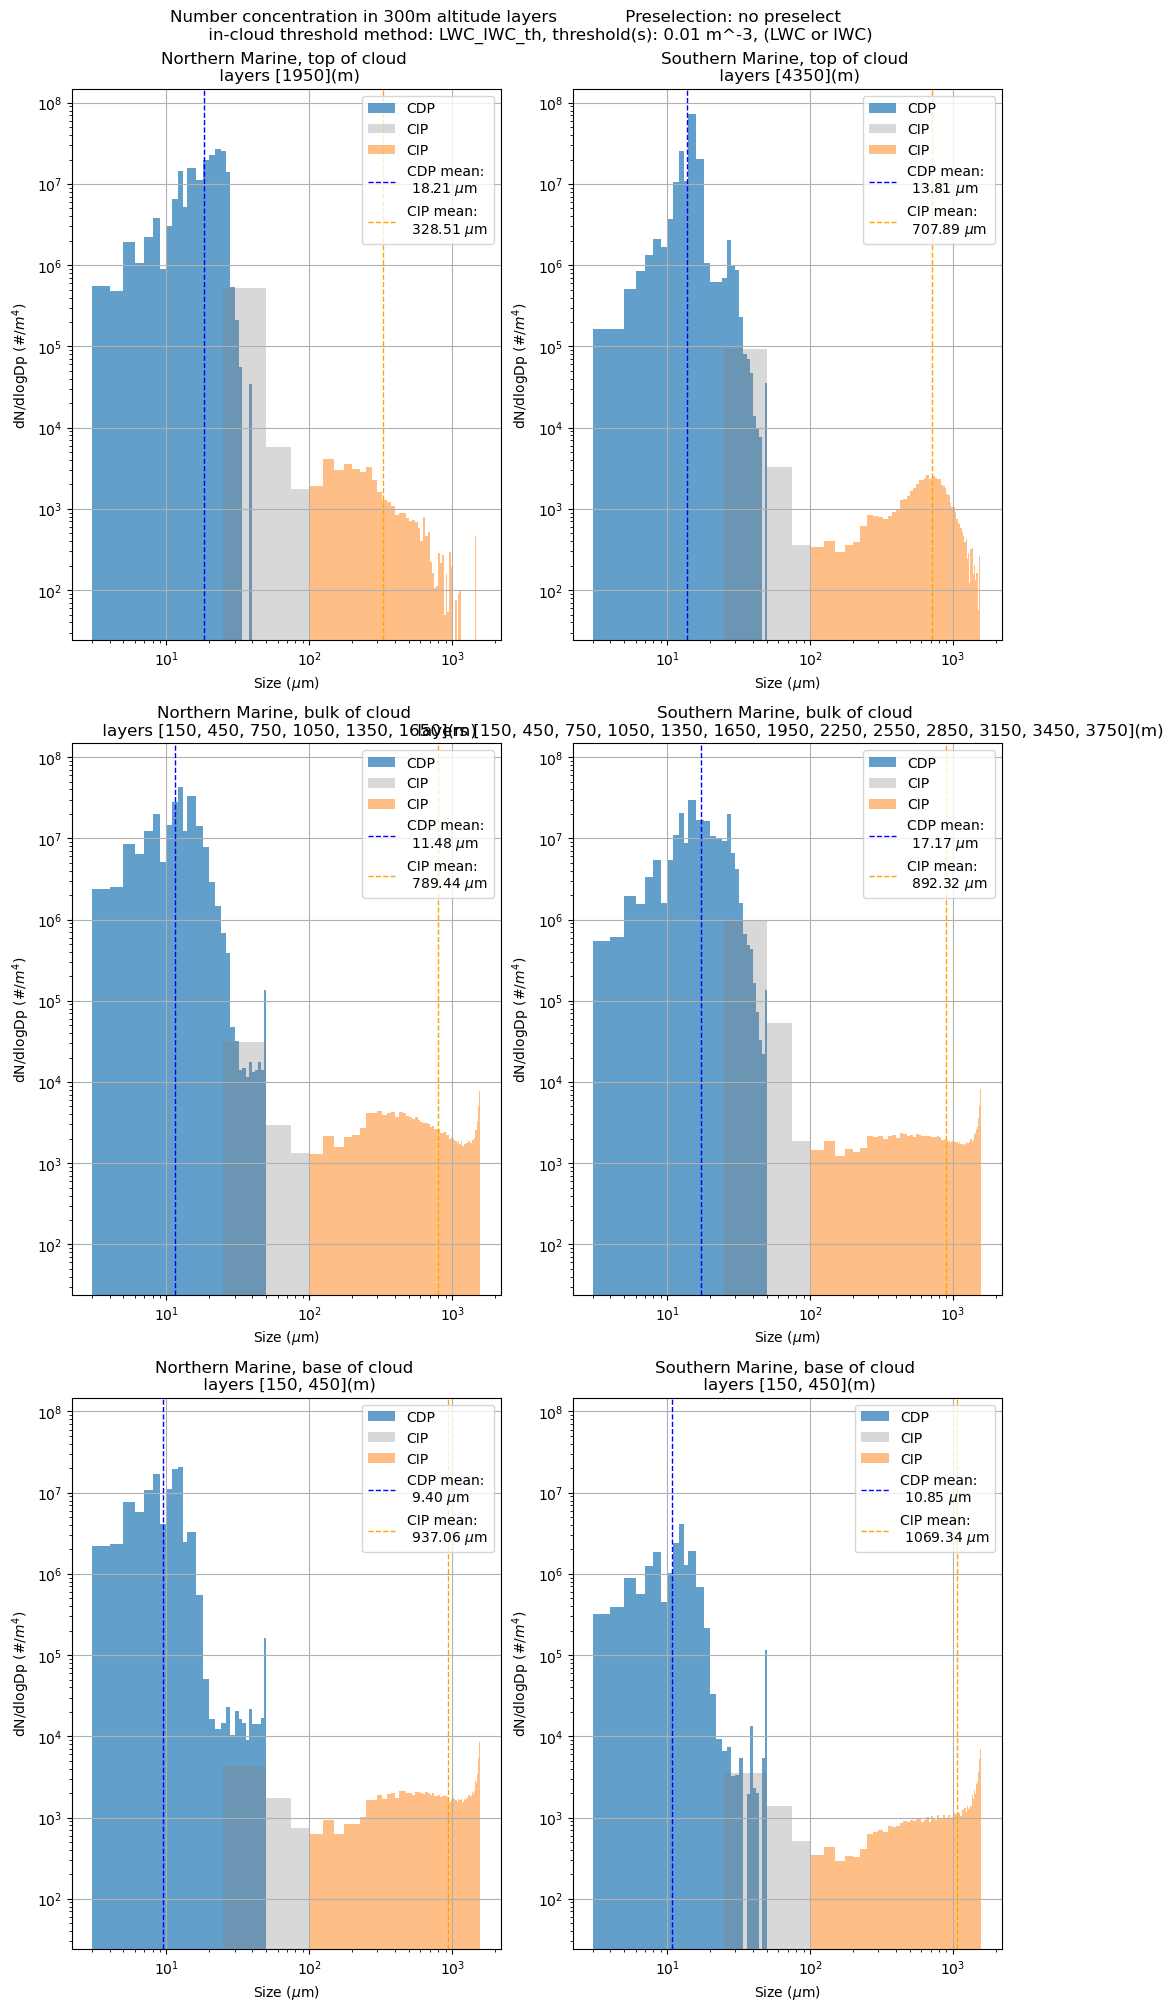

In [25]:
##### --- Plotting number concentrations original
fig, ax = plt.subplots(3, 2, figsize=(10, 20), layout="constrained", sharey=True)

# Northern Marine, Top Layer

def numb_conc_plot(ax, ds, cat_text):
    import matplotlib as plt
    import numb_conc # number concentration functions
    
    # Get the normalized values for plotting (from functions in numb_conc)
    cip_part_norm = numb_conc.cip_mean_norm_Nt(ds)
    cdp_part_norm = numb_conc.cdp_mean_norm_Nt(ds)

    # plot histogram based on normalized data and binning size information for CDP and CIP
    ax.hist(ds['Size'].values, weights = cdp_part_norm.values, bins=ds['Size'].values, label = "CDP", histtype='stepfilled', alpha = 0.7)

    midbins = ds['MIDBINS'].values
    weights = cip_part_norm.values
    ax.hist(midbins[:3], weights=weights[:3], bins=midbins[:4], label="CIP", color='grey', histtype='stepfilled', alpha=0.3)# Plot first three bins in grey
    ax.hist(midbins[3:], weights=weights[3:], bins=midbins[3:], label="CIP", histtype='stepfilled', alpha = 0.5)


    # --- calculate mean number concentration from the histogram 
    # - CDP
    prod_val_count_cdp = ds['Size'].values*cdp_part_norm.values
    tot_sum = prod_val_count_cdp.sum()
    counts= cdp_part_norm.values
    count_sum = counts.sum()
    mean_size_cdp = tot_sum/count_sum
    # set as vertical line in plot
    ax.axvline(mean_size_cdp, color='blue', linestyle='dashed', linewidth=1, label=f'CDP mean: \n {mean_size_cdp:.2f} $\mu$m')
    
    # - CIP
    # Only calculate the mean on the bins that are not greyed out (the first 3 bins)
    prod_val_count_cip = cip_part_norm.values*ds['MIDBINS'].values
    tot_sum = prod_val_count_cip[3:].sum()
    count_sum = cip_part_norm.values[3:].sum()
    mean_size_cip = tot_sum/count_sum
    # set as vertical line in plot
    ax.axvline(mean_size_cip, color='orange', linestyle='dashed', linewidth=1, label=f'CIP mean: \n {mean_size_cip:.2f} $\mu$m')

    # set labels, titles and legends for subplots
    ax.set_ylabel('dN/dlogDp (#/$m^4$)')
    ax.set_xlabel('Size ($\mu$m)')
    ax.set_title(cat_text)
    ax.legend(loc='upper right')

# Top layers
numb_conc_plot(ax[0,0], north_top_ds, f'Northern Marine, top of cloud \n layers {n_top_list}(m)')
numb_conc_plot(ax[0,1], south_top_ds, f'Southern Marine, top of cloud \n layers {s_top_list}(m)')

# Bulk layers
numb_conc_plot(ax[1,0], north_bulk_ds, f'Northern Marine, bulk of cloud \n layers {n_bulk_list}(m)')
numb_conc_plot(ax[1,1], south_bulk_ds, f'Southern Marine, bulk of cloud \n layers {s_bulk_list}(m)')

# Base layers
numb_conc_plot(ax[2,0], north_base_ds, f'Northern Marine, base of cloud \n layers {n_base_list}(m)')
numb_conc_plot(ax[2,1], south_base_ds, f'Southern Marine, base of cloud \n layers {s_base_list}(m)')

# Precip layer
#numb_conc_plot(ax[3,0], north_precip_ds, f'Northern Marine, precip layer \n {n_precip_list}(m)')
#numb_conc_plot(ax[3,1], south_precip_ds, f'Southern Marine, precip layer \n {s_precip_list}(m)')

# --- Subplot settings
for ax in ax.ravel():  # Flatten the array of axes and iterate
    ax.set_xscale('log')  # Set x-axis to log scale
    ax.set_yscale('log')  # Set y-axis to log scale
    ax.grid(True)
    #ax.label_outer()  # This method hides only labels in the inner axes; keep it commented out to show labels
    ax.yaxis.set_tick_params(which='both', labelleft=True)
    ax.xaxis.set_tick_params(which='both', labelbottom=True)

# --- Figure 
plt.suptitle(f'Number concentration in 300m altitude layers \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/Nt_Latitude_bands_{th_method}{preopt}.png') # Save to
plt.show()


In [26]:
# --- Prep-work for other plots

# Select variables to plot
sel_vars = ['TWC','IWC100', 'LWC corr','SLF', 'region', 'altitude_bin', 'T']

# creating dataframes for easier reuse of plots
north_df = north_ds[sel_vars].to_dataframe().reset_index()
south_df = south_ds[sel_vars].to_dataframe().reset_index()

In [27]:
north_ds

<xarray.Dataset> Size: 8MB
Dimensions:                 (time: 2035, Vector64: 64, Vector40: 40, CDP_Bin: 30)
Coordinates:
  * time                    (time) datetime64[ns] 16kB 2022-03-24T10:46:19 .....
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    lat                     (time) float32 8kB 76.62 76.63 76.64 ... 74.96 74.95
    lon                     (time) float32 8kB 10.95 10.95 10.95 ... 20.88 20.88
    alt                     (time) float32 8kB 1.908e+03 1.873e+03 ... 840.7
    altitude_bin            (time) int64 16kB 1950 1950 1950 ... 450 750 750
Dimensions without coordinates: Vector64, Vector40
Data variables: (12/80)
    base_time               (time) datetime64[ns] 16kB 2022-03-24T08:04:25 .....
    utc_time                (time) float64 16kB dask.array<chunksize=(2035,), meta=np.ndarray>
    TAS                     (time) float32 8kB dask.array<chunksize=(2035,), meta=np.ndarray>
    MIDBINS                 (time, Vector64) float32 521kB dask.array<chunksize=(2035, 64), meta=np.ndarray>
    ACTIVETIME              (time) float32 8kB dask.array<chunksize=(2035,), meta=np.ndarray>
    SA                      (time, Vector64) float32 521kB dask.array<chunksize=(2035, 64), meta=np.ndarray>
    ...                      ...
    surface_cond            (time) object 16kB dask.array<chunksize=(2035,), meta=np.ndarray>
    in_cloud_lwc            (time) float64 16kB dask.array<chunksize=(2035,), meta=np.ndarray>
    in_cloud_twc            (time) float64 16kB dask.array<chunksize=(2035,), meta=np.ndarray>
    in_cloud                (time) float64 16kB dask.array<chunksize=(2035,), meta=np.ndarray>
    Relevance               (time) object 16kB dask.array<chunksize=(2035,), meta=np.ndarray>
    region                  (time) object 16kB 'north' 'north' ... 'north'
Attributes:
    date_modified:              2025-04-04
    Joint dataset sample rate:  5.0
    CDP sample area:            0.269
    CDP sample area unit:       mm²
    incloud_thres:              0.01

In [28]:
# plots I want to complete:
# - the SLF plots
# - histograms of area ratio and aspect ratio, mean and max per size bin (divided by region and cloud layer)


# what about area ratio? and aspect ratio?
# The area ratio a, the projected area of a particle divided by the area of a circle with diameter Dmax, quantified particle shape.
# \cite MCFARQUHAR et al 2013
# meaning that an area ratio of 1 will be a water droplet and an area ratio close to 0 will be an ice needle. 
# in the article alpha <0.8 is ice 

# Aspect ratio: (AR, the dimension of the major axis divided by the dimension of the minor axis) \cite Uhm et al. 2015
# meaning the aspect ratio of 1 will be a round water droplet

# create a plot that shows the mean(mean_aspectratio) per bin and the max(mean_aspectratio) in the same plot
# ultimate goal: make this type of plot for all of the categories to see if changes during region or altitude bins.

#ds_incloud['MEAN_ASPECTRATIO'].groupby(

# Create the means and maxes per bin for the whole dataset (both area ratio and aspect ratio
mean_arear = ds_incloud['MEAN_AREARATIO'].mean(dim='time')
mean_aspectr = ds_incloud['MEAN_ASPECTRATIO'].mean(dim='time')
min_arear = ds_incloud['MEAN_AREARATIO'].min(dim='time')
min_aspectr = ds_incloud['MEAN_ASPECTRATIO'].min(dim='time')


# log normalize if needed
# log normalize the cdp particle counts to width (Size = upper limit of bin, Bin_min = lower limit of bin)
# bin units are in micrometers and must be adjusted to m
# log_norm_width = np.log(ds['Size']*1.e-6)-np.log(ds['Bin_min']*1.e-6)
# cdp_part_norm = cdp_part_mean/log_norm_width  #normalize to bin width
weights = mean_arear.values

# Plots
midbins = ds_incloud['MIDBINS'][0].values
ds_incloud['MEAN_AREARATIO'].attrs['long_name']


'Mean Area Ratio Per Size Bin'

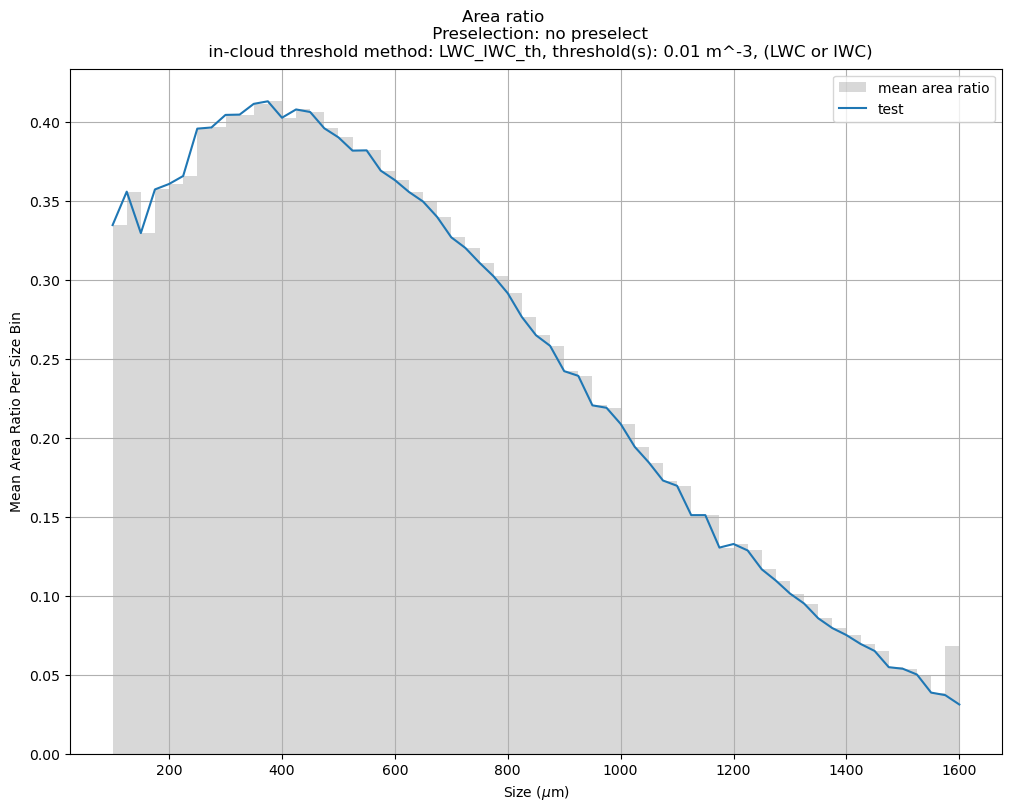

In [29]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8), layout="constrained", sharey=True)
    

ax.hist(midbins[3:], weights=weights[3:], bins=midbins[3:], label="mean area ratio", color='grey', histtype='stepfilled', alpha=0.3)# Plot first three bins in grey
#ax.hist(midbins[3:], weights=min_arear[3:], bins=midbins[3:], label="CIP", histtype='stepfilled', alpha = 0.5)
ax.plot(midbins[3:], weights[3:], label = 'test')


# set labels, titles and legends for subplots
ax.set_ylabel(ds_incloud['MEAN_AREARATIO'].attrs['long_name'])
ax.set_xlabel('Size ($\mu$m)')
#ax.set_title(cat_text)
ax.legend(loc='upper right')

# --- Subplot settings
#ax.set_xscale('log')  # Set x-axis to log scale
#ax.set_yscale('log')  # Set y-axis to log scale
ax.grid(True)
#ax.label_outer()  # This method hides only labels in the inner axes; keep it commented out to show labels
ax.yaxis.set_tick_params(which='both', labelleft=True)
ax.xaxis.set_tick_params(which='both', labelbottom=True)

# --- Figure 
plt.suptitle(f'Area ratio \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
#plt.savefig(save_path+f'{th_method}/Nt_Latitude_bands_{th_method}{preopt}.png') # Save to
plt.show()


In [30]:
ds_incloud

<xarray.Dataset> Size: 22MB
Dimensions:                 (time: 5654, Vector64: 64, Vector40: 40, CDP_Bin: 30)
Coordinates:
  * time                    (time) datetime64[ns] 45kB 2022-03-22T11:39:01 .....
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    lat                     (time) float32 23kB 70.2 70.22 70.22 ... 74.96 74.95
    lon                     (time) float32 23kB 20.38 20.37 ... 20.88 20.88
    alt                     (time) float32 23kB 3.863e+03 3.866e+03 ... 840.7
    altitude_bin            (time) int64 45kB 3750 3750 3750 ... 450 750 750
Dimensions without coordinates: Vector64, Vector40
Data variables: (12/80)
    base_time               (time) datetime64[ns] 45kB 2022-03-22T11:37:21 .....
    utc_time                (time) float64 45kB dask.array<chunksize=(1885,), meta=np.ndarray>
    TAS                     (time) float32 23kB dask.array<chunksize=(1885,), meta=np.ndarray>
    MIDBINS                 (time, Vector64) float32 1MB dask.array<chunksize=(1885, 64), meta=np.ndarray>
    ACTIVETIME              (time) float32 23kB dask.array<chunksize=(1885,), meta=np.ndarray>
    SA                      (time, Vector64) float32 1MB dask.array<chunksize=(1885, 64), meta=np.ndarray>
    ...                      ...
    surface_cond            (time) object 45kB dask.array<chunksize=(1885,), meta=np.ndarray>
    in_cloud_lwc            (time) float64 45kB dask.array<chunksize=(1885,), meta=np.ndarray>
    in_cloud_twc            (time) float64 45kB dask.array<chunksize=(1885,), meta=np.ndarray>
    in_cloud                (time) float64 45kB dask.array<chunksize=(1885,), meta=np.ndarray>
    Relevance               (time) object 45kB dask.array<chunksize=(1885,), meta=np.ndarray>
    region                  (time) object 45kB 'south' 'south' ... 'north'
Attributes:
    date_modified:              2025-04-04
    Joint dataset sample rate:  5.0
    CDP sample area:            0.269
    CDP sample area unit:       mm²
    incloud_thres:              0.01

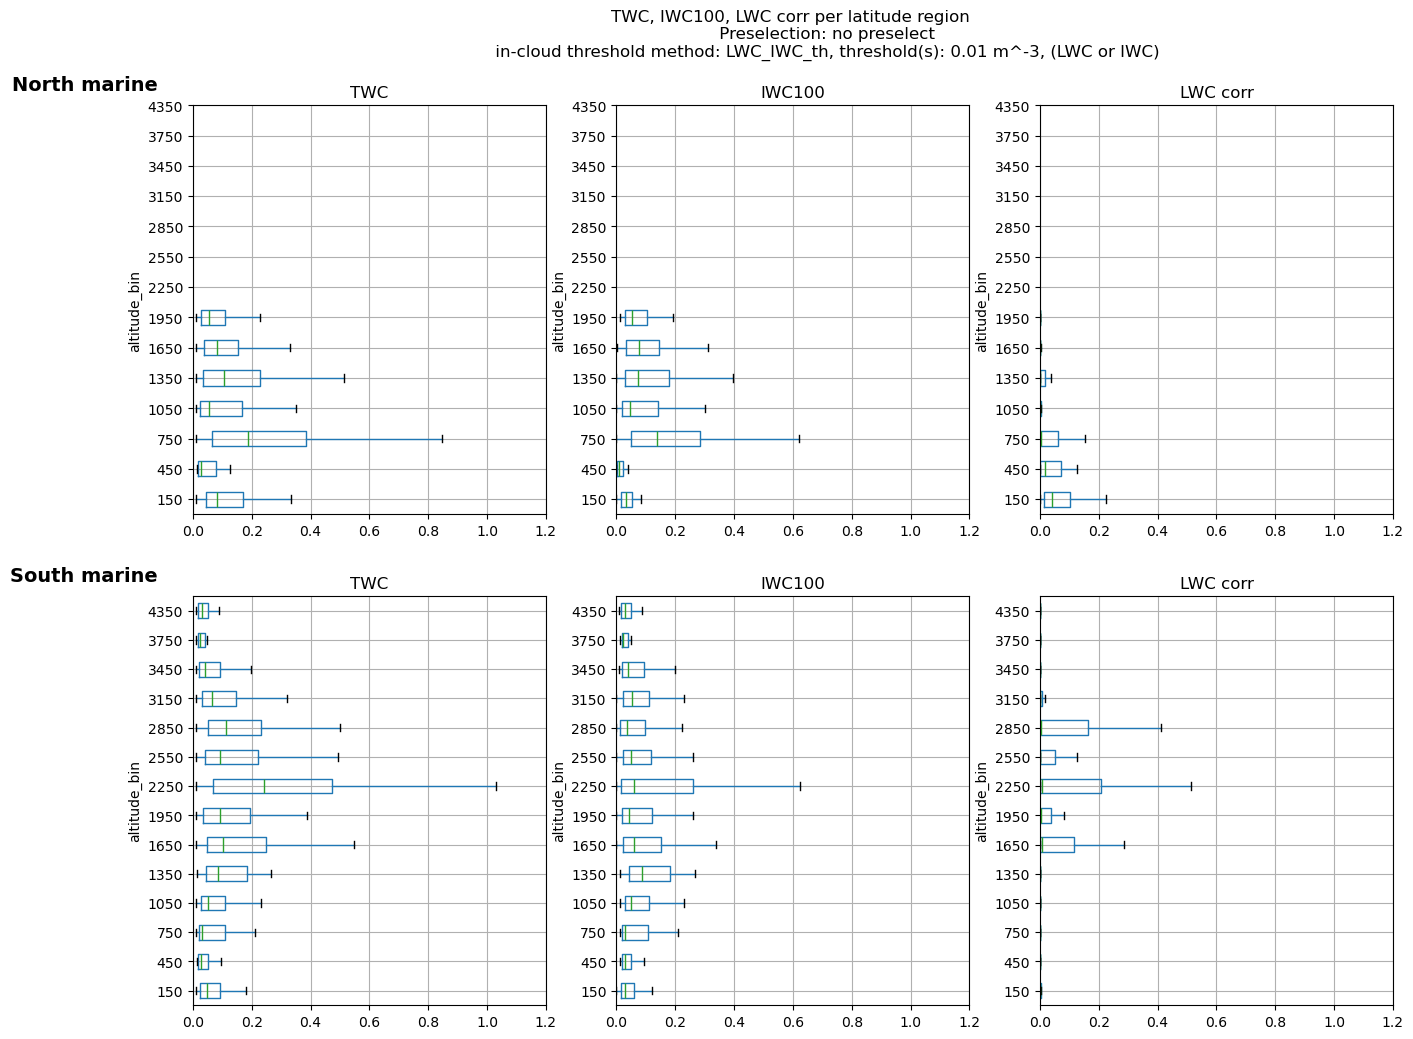

In [31]:
# -- BOXPLOT: Water content, original

# Define the dataframes and columns
row_titles = ['North marine','South marine']
dfs = [north_df, south_df]
var = ['TWC', 'IWC100','LWC corr']

# Get list of all available altitude categories in the full dataset
alt_cats = np.unique(ds_incloud['altitude_bin'].values)

# subplotsize
n_rows = len(var)

fig, ax = plt.subplots(2, n_rows, figsize=(15, 12))


# Plot the data and add the count of observations
for col, df in enumerate(dfs):
    alt_bins = df['altitude_bin'].unique()
    positions = [np.where(alt_cats == alt)[0][0] + 1 for alt in alt_bins]
    for row, v in enumerate(var):
        df.boxplot(column= v, by='altitude_bin', ax=ax[col, row], positions=positions, vert=False, showfliers=False)
        ax[col, row].set_yticks(range(1, len(alt_cats) + 1))
        ax[col, row].set_yticklabels(alt_cats)

        if col == len(var) - 1:
            # Add counts only to the last plot
            counts = df['altitude_bin'].value_counts() #get the number of observations per altitude bin
            for group, count in counts.items():
                # for each item in the counts per altitude bin:
                # 1: find out where it is located in the array of sorted altitude bins
                # 2: plot the count as text by the boxplot located at this location.
                index_of_group = np.where(alt_cats==group)[0] +1  # change from 0 base to 1 base
                ax[row,0].text(1, index_of_group, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
           

# Set titles for each row
for i, title in enumerate(row_titles):
    ax[i, 0].text(-0.1, 1.05, title, transform=ax[i, 0].transAxes, fontsize=14, fontweight='bold', va='center', ha='right')

# Adjust layout
plt.setp(ax, xlim=(0, 1.2))
#plt.setp(ax, xlim=(0, 3.5)) # lims for showfliers = True


# --- Figure 
plt.suptitle(f'{', '.join(str(e) for e in var)} per latitude region \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/LWC_IWC_TWC_per_lat_region_{th_method}{preopt}.png') # Save to
plt.show()


In [32]:
ds_incloud['T'].attrs

{'units': 'Celsius',
 'long_name': 'Air Static Temperature, deiced sensor',
 'comment': 'Corrected from speed and recovery factor',
 'origin': 'tpr_ttbrtd_comp_1',
 'source': ' Rosemount : E102AL: 3398; Rosemount : 1221F2AF7B1B: 783; Thales : ADM: 8952'}

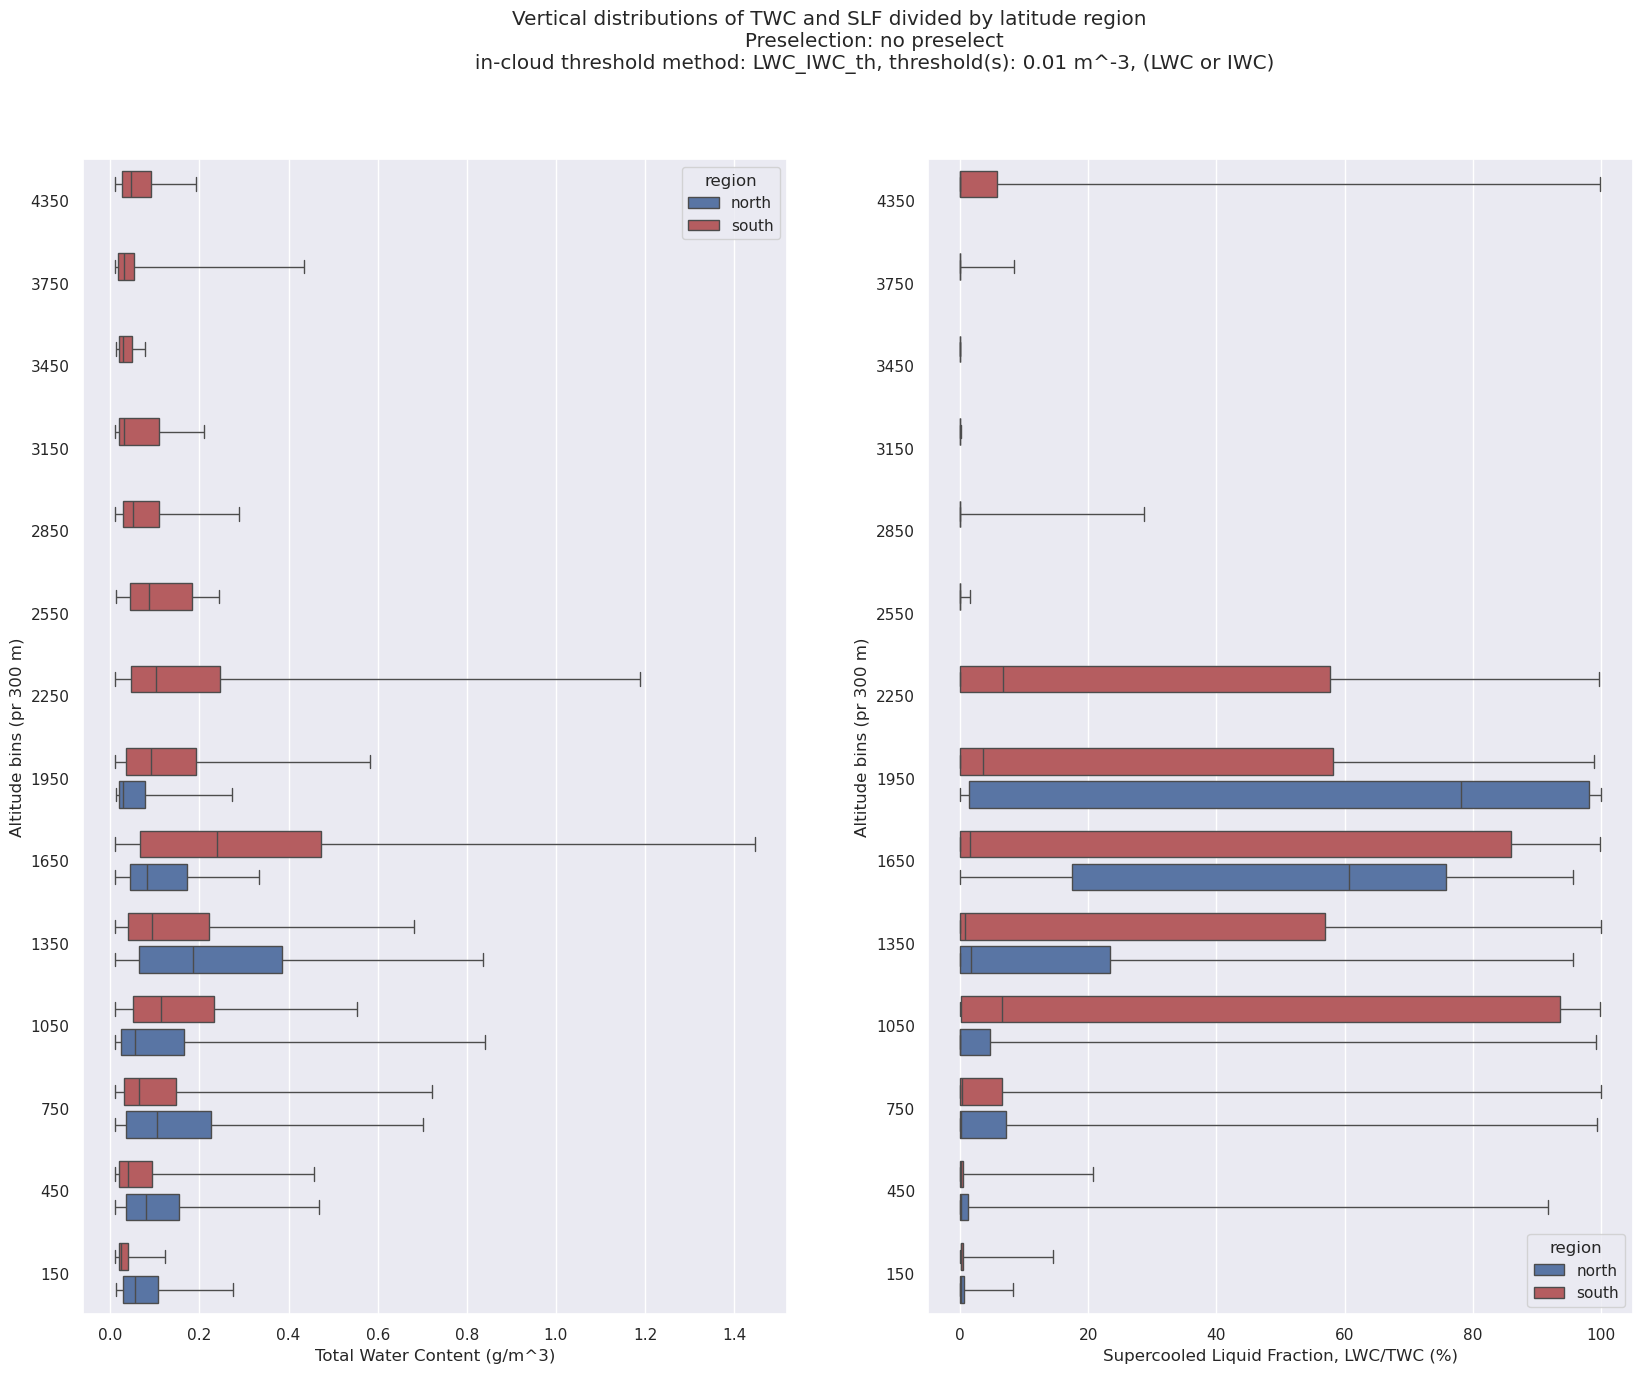

In [33]:
# -- BOXPLOT: Total water content and SLF


import seaborn as sns

sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(1,2, figsize=(20, 15))

twc_p = sns.boxplot(data= ds_incloud, y ='altitude_bin', x='TWC', hue='region', whis=(0,99), gap=.2,
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[0],
           showfliers=False)
slf_p = sns.boxplot(data= ds_incloud, y ='altitude_bin', x='SLF_all', hue='region', whis=(0,99), gap=.2, 
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[1],
           showfliers=False)

for a in ax:
    a.set_ylim(reversed(a.get_ylim()))  # Reversing the y-axis for each subplot

twc_p.set(xlabel=f"Total Water Content ({ds_incloud['TWC'].attrs['unit']})", ylabel="Altitude bins (pr 300 m)")
slf_p.set(xlabel=f"Supercooled Liquid Fraction, LWC/TWC (%)", ylabel="Altitude bins (pr 300 m)")
#plt.setp(ax, xlim=(-0.01, 3.5))  

# --- Figure 
plt.suptitle(f'Vertical distributions of TWC and SLF divided by latitude region \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/WITHOUT_OUTLIERS_seaborn_WC_per_Latitude_region_{th_method}{preopt}.png') # Save to
plt.show()

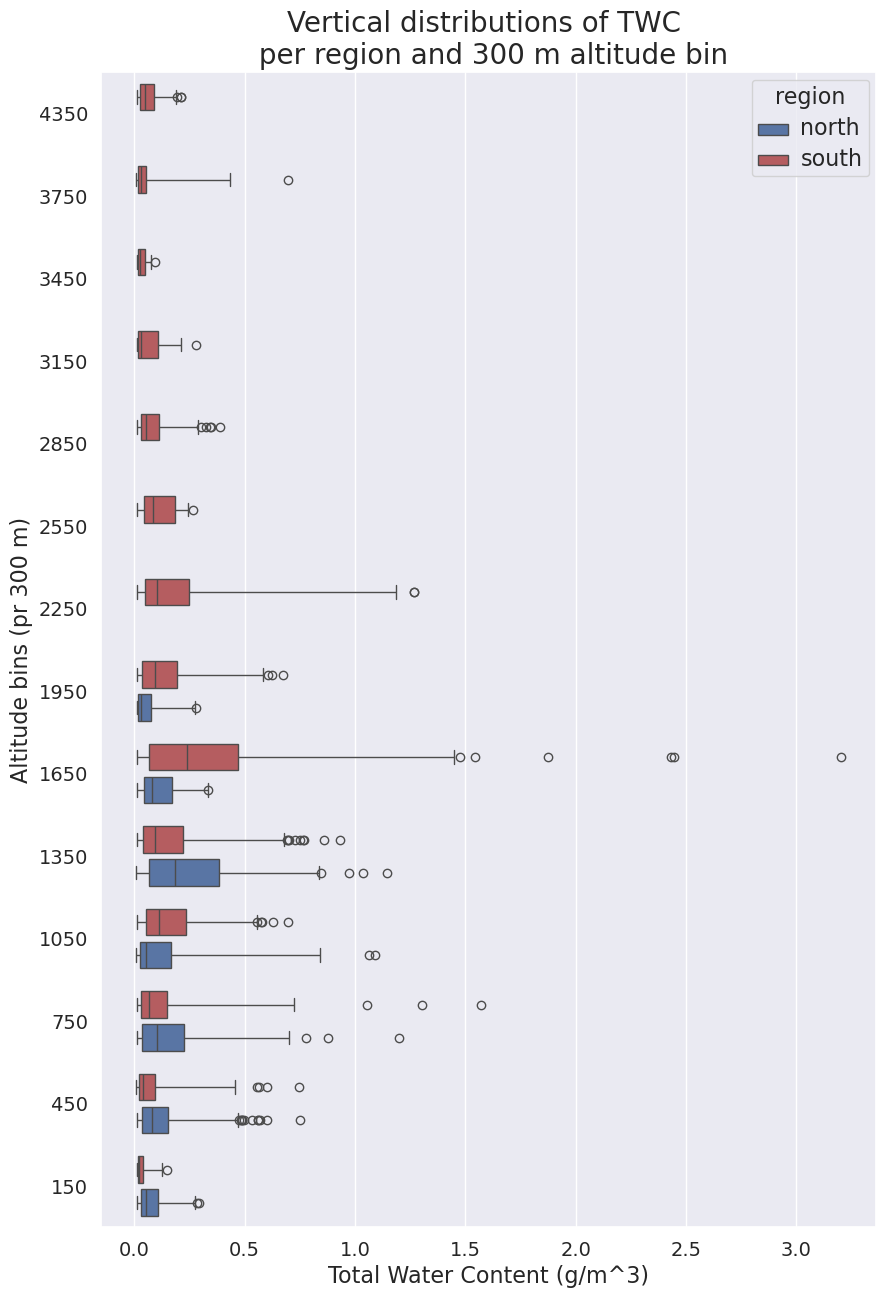

In [34]:
# -- BOXPLOT: Total water content
import seaborn as sns

sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(figsize=(10, 15))

twc_p = sns.boxplot(data = ds_incloud, y ='altitude_bin', x='TWC', hue='region', whis=(0,99), gap=.2,
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax,
           showfliers=True)

ax.set_ylim(reversed(twc_p.get_ylim()))  # Reversing the y-axis for each subplot

# titles and adjust fontzises
twc_p.axes.set_title(f'Vertical distributions of TWC \n per region and 300 m altitude bin',fontsize=20)
twc_p.set_xlabel(f"Total Water Content ({ds_incloud['TWC'].attrs['unit']})",fontsize=16)
twc_p.set_ylabel("Altitude bins (pr 300 m)",fontsize=16)
twc_p.tick_params(labelsize=14)
plt.setp(twc_p.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(twc_p.get_legend().get_title(), fontsize='16')

# --- Figure 
#plt.suptitle(f'Vertical distributions of TWC pr region and 300 m altitude bin \n \
#            Preselection: {pre_text}\n \
#            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/WITHOUT_OUTLIERS_seaborn_TWC_per_Latitude_region_{th_method}{preopt}.png') # Save to
plt.show()

In [35]:
ds_incloud['test'] = ds_incloud['LWC corr']/ds_incloud['TWC']
ds_incloud['test']

<xarray.DataArray 'test' (time: 5654)> Size: 45kB
dask.array<truediv, shape=(5654,), dtype=float64, chunksize=(1885,), chunktype=numpy.ndarray>
Coordinates:
  * time          (time) datetime64[ns] 45kB 2022-03-22T11:39:01 ... 2022-04-...
    lat           (time) float32 23kB 70.2 70.22 70.22 ... 75.0 74.96 74.95
    lon           (time) float32 23kB 20.38 20.37 20.37 ... 20.89 20.88 20.88
    alt           (time) float32 23kB 3.863e+03 3.866e+03 ... 812.7 840.7
    altitude_bin  (time) int64 45kB 3750 3750 3750 3750 3750 ... 450 450 750 750

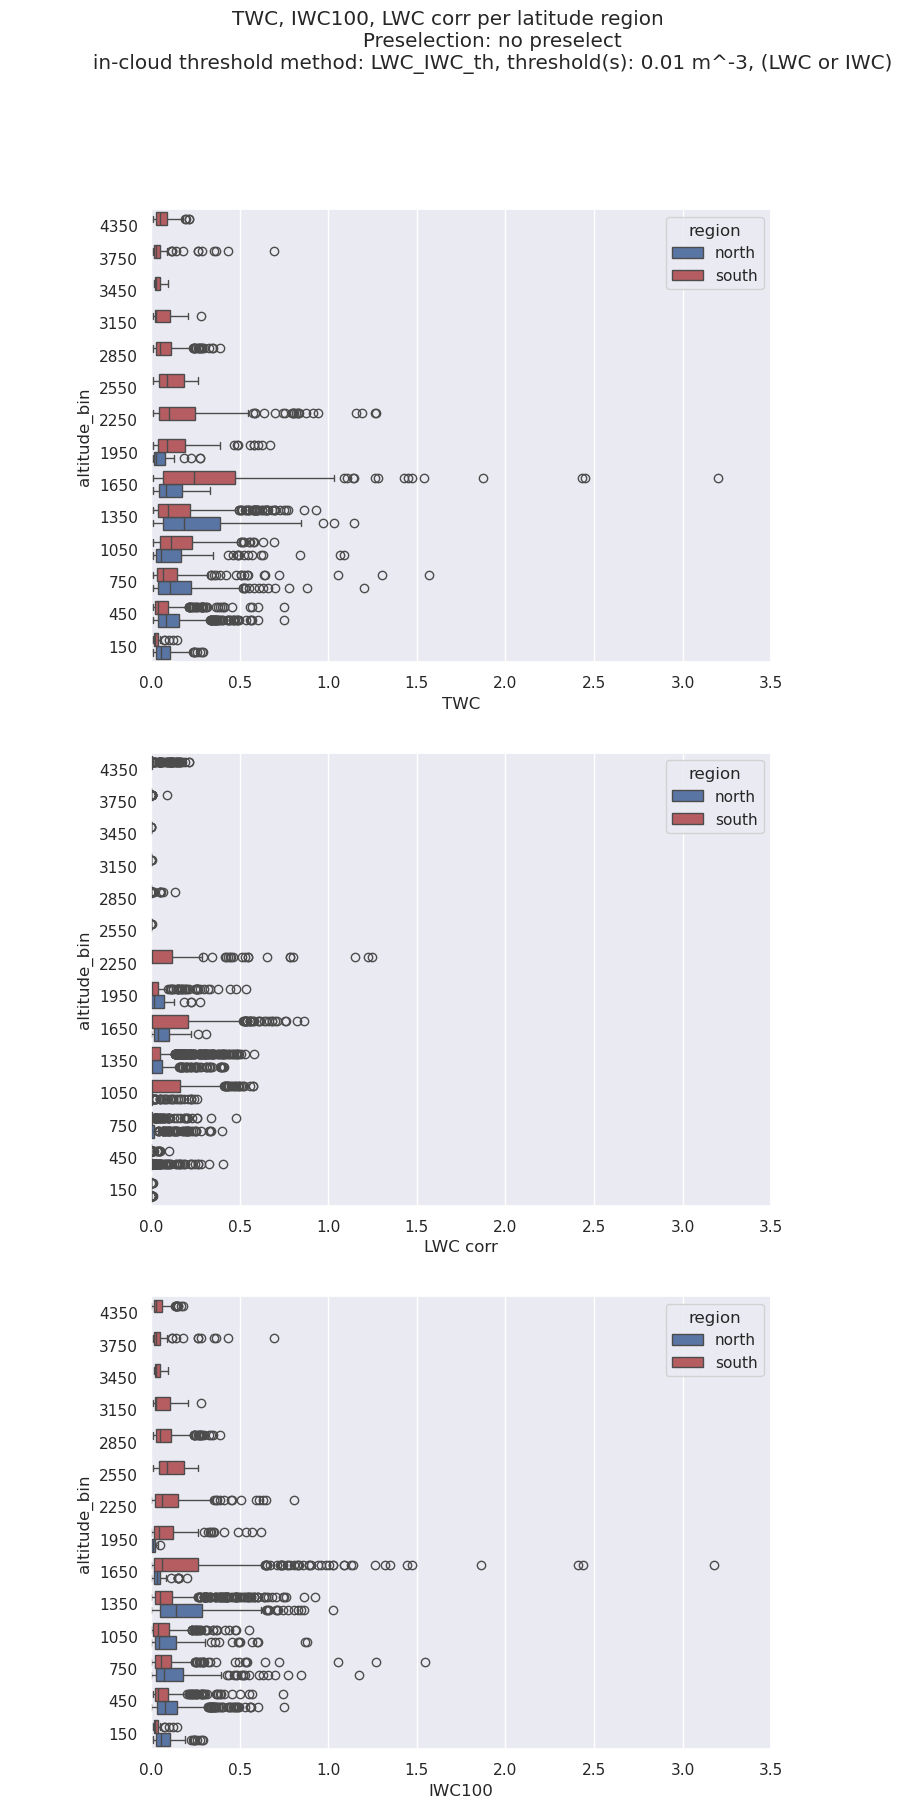

In [36]:
# -- BOXPLOT: Water contents, southern and northern in same plot (OLD)

import seaborn as sns

sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(3,1, figsize=(8, 20))

sns.boxplot(data= ds_incloud, y ='altitude_bin', x='TWC', hue='region',  
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[0],
           showfliers=True)
sns.boxplot(data= ds_incloud, y ='altitude_bin', x='LWC corr', hue='region',  
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[1],
           showfliers=True)
sns.boxplot(data= ds_incloud, y ='altitude_bin', x='IWC100', hue='region',  
            palette=dict(north='b', south='r'), 
            width=0.8, orient = 'h', ax=ax[2],
           showfliers=True)

for a in ax:
    a.set_ylim(reversed(a.get_ylim()))  # Reversing the y-axis for each subplot

plt.setp(ax, xlim=(0, 3.5))  

# --- Figure 
plt.suptitle(f'{', '.join(str(e) for e in var)} per latitude region \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/seaborn_WC_per_Latitude_region_{th_method}{preopt}.png') # Save to
plt.show()

In [37]:
# -- southern marine
# get the mean values per height bin
s_twc_mean = south_df.groupby('altitude_bin')['TWC'].mean()
s_lwc_mean = south_df.groupby('altitude_bin')['LWC corr'].mean()
s_iwc_mean = south_df.groupby('altitude_bin')['IWC100'].mean()
s_t_mean = south_df.groupby('altitude_bin')['T'].mean() # temperature

# get the std values per height bin
s_twc_std = south_df.groupby('altitude_bin')['TWC'].std()
s_lwc_std = south_df.groupby('altitude_bin')['LWC corr'].std()
s_iwc_std = south_df.groupby('altitude_bin')['IWC100'].std()
s_t_std = south_df.groupby('altitude_bin')['T'].std()

# get the max values per height bin
s_twc_mx = south_df.groupby('altitude_bin')['TWC'].max()
s_lwc_mx = south_df.groupby('altitude_bin')['LWC corr'].max()
s_iwc_mx = south_df.groupby('altitude_bin')['IWC100'].max()
s_t_mx = south_df.groupby('altitude_bin')['T'].max()

# get the std values per height bin
s_twc_mn = south_df.groupby('altitude_bin')['TWC'].min()
s_lwc_mn = south_df.groupby('altitude_bin')['LWC corr'].min()
s_iwc_mn = south_df.groupby('altitude_bin')['IWC100'].min()
s_t_mn = south_df.groupby('altitude_bin')['T'].min()

# -- nothern marine
n_twc_mean = north_df.groupby('altitude_bin')['TWC'].mean()
n_lwc_mean = north_df.groupby('altitude_bin')['LWC corr'].mean()
n_iwc_mean = north_df.groupby('altitude_bin')['IWC100'].mean()
n_t_mean = north_df.groupby('altitude_bin')['T'].mean()

# get the std values per height bin
n_twc_std = north_df.groupby('altitude_bin')['TWC'].std()
n_lwc_std = north_df.groupby('altitude_bin')['LWC corr'].std()
n_iwc_std = north_df.groupby('altitude_bin')['IWC100'].std()
n_t_std = north_df.groupby('altitude_bin')['T'].std()

# get the max values per height bin
n_twc_mx = north_df.groupby('altitude_bin')['TWC'].max()
n_lwc_mx = north_df.groupby('altitude_bin')['LWC corr'].max()
n_iwc_mx = north_df.groupby('altitude_bin')['IWC100'].max()
n_t_mx = north_df.groupby('altitude_bin')['T'].max()

# get the std values per height bin
n_twc_mn = north_df.groupby('altitude_bin')['TWC'].min()
n_lwc_mn = north_df.groupby('altitude_bin')['LWC corr'].min()
n_iwc_mn = north_df.groupby('altitude_bin')['IWC100'].min()
n_t_mn = north_df.groupby('altitude_bin')['T'].min()

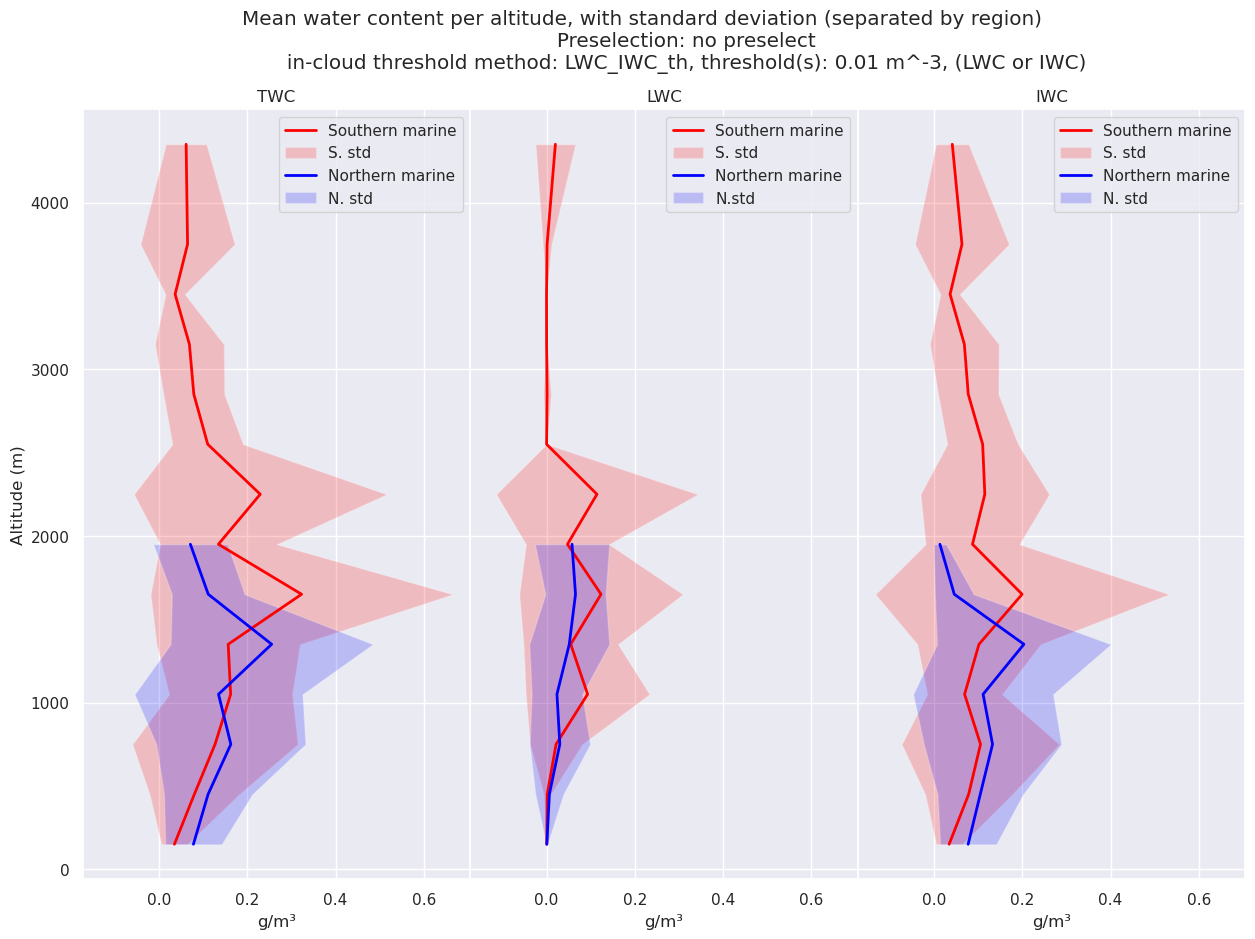

In [38]:
# plotting the mean and the spread (std) per height


# plot the values
fig = plt.figure(figsize=(15,10))
gs = fig.add_gridspec(1,3, wspace=0)
axs = gs.subplots(sharey=True, sharex=True)

# TWC southern and northern marine
axs[0].plot(s_twc_mean, s_twc_mean.index, label = 'Southern marine', lw=2,color = 'red')
axs[0].fill_betweenx(s_twc_mean.index, s_twc_mean+s_twc_std, s_twc_mean-s_twc_std, facecolor='red', alpha=0.2, label='S. std')

axs[0].plot(n_twc_mean, n_twc_mean.index, label = 'Northern marine', lw=2,color = 'blue')
axs[0].fill_betweenx(n_twc_mean.index, n_twc_mean+n_twc_std, n_twc_mean-n_twc_std, facecolor='blue', alpha=0.2, label='N. std')

axs[0].set_title('TWC')
axs[0].set_ylabel('Altitude (m)')
axs[0].set_xlabel('g/m³')
axs[0].legend(loc='upper right')


# LWC southern and northern marine
axs[1].plot(s_lwc_mean, s_lwc_mean.index, label = 'Southern marine', lw=2,color = 'red')
axs[1].fill_betweenx(s_lwc_mean.index, s_lwc_mean+s_lwc_std, s_lwc_mean-s_lwc_std, facecolor='red', alpha=0.2, label='S. std')

axs[1].plot(n_lwc_mean, n_lwc_mean.index, label = 'Northern marine', lw=2,color = 'blue')
axs[1].fill_betweenx(n_lwc_mean.index, n_lwc_mean+n_lwc_std, n_lwc_mean-n_lwc_std, facecolor='blue', alpha=0.2, label='N.std')

axs[1].set_title('LWC')
axs[1].set_xlabel('g/m³')
axs[1].legend(loc='upper right')


# IWC southern and northern marine
axs[2].plot(s_iwc_mean, s_iwc_mean.index, label = 'Southern marine', lw=2,color = 'red')
axs[2].fill_betweenx(s_iwc_mean.index, s_iwc_mean+s_iwc_std, s_iwc_mean-s_iwc_std, facecolor='red', alpha=0.2, label='S. std')

axs[2].plot(n_iwc_mean, n_iwc_mean.index, label = 'Northern marine', lw=2,color = 'blue')
axs[2].fill_betweenx(n_iwc_mean.index, n_iwc_mean+n_iwc_std, n_iwc_mean-n_iwc_std, facecolor='blue', alpha=0.2, label='N. std')

axs[2].set_title('IWC')
axs[2].set_xlabel('g/m³')
axs[2].legend(loc='upper right')


# --- Figure 
plt.suptitle(f'Mean water content per altitude, with standard deviation (separated by region) \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.savefig(save_path+f'{th_method}/mean_LWC_TWC_IWC_regionvise_{th_method}{preopt}.png') # Save to
plt.show()

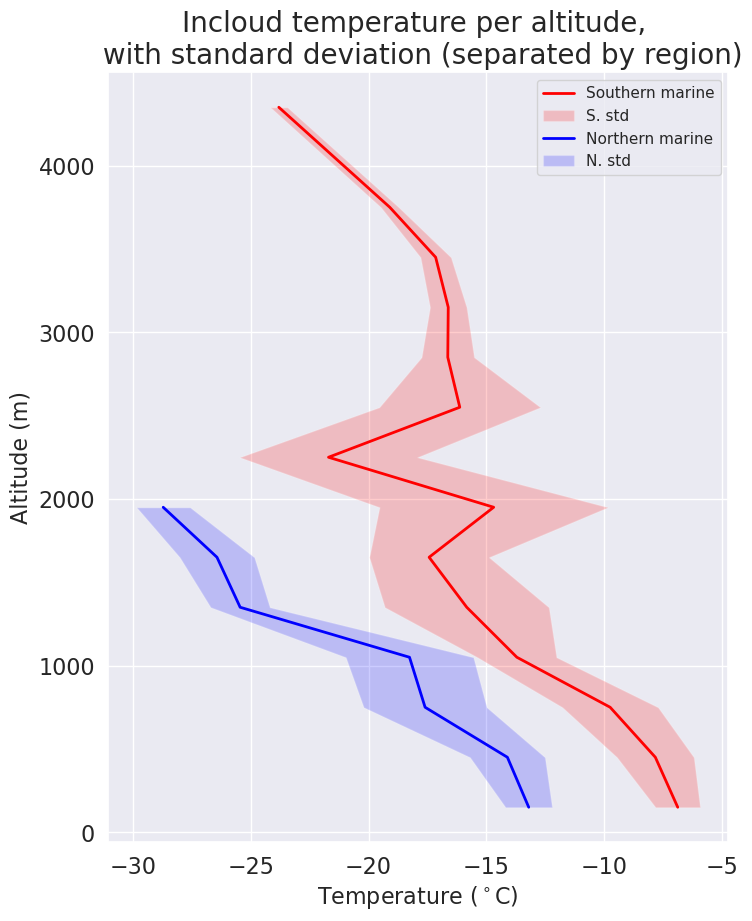

In [39]:
# mean temperature  per altitude per region, with standard deviation

# plot the values
fig, ax = plt.subplots(figsize=(8,10))

# Temperature southern and northern marine
ax.plot(s_t_mean, s_t_mean.index, label = 'Southern marine', lw=2,color = 'red')
ax.fill_betweenx(s_t_mean.index, s_t_mean+s_t_std, s_t_mean-s_t_std, facecolor='red', alpha=0.2, label='S. std')

ax.plot(n_t_mean, n_t_mean.index, label = 'Northern marine', lw=2,color = 'blue')
ax.fill_betweenx(n_t_mean.index, n_t_mean+n_t_std, n_t_mean-n_t_std, facecolor='blue', alpha=0.2, label='N. std')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel('Altitude (m)', fontsize = 16)
ax.set_xlabel('Temperature ($^\circ$C)', fontsize = 16)
ax.legend(loc='upper right')


# --- Figure 
#plt.suptitle(f'Incloud temperature per altitude, with standard deviation (separated by region) \n \
#            Preselection: {pre_text}\n \
#            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
plt.title(f'Incloud temperature per altitude, \n with standard deviation (separated by region)', fontsize=20)
plt.savefig(save_path+f'{th_method}/mean_T_regionvise_{th_method}{preopt}.png') # Save to
plt.show()

## SLF plots 

In [40]:
# extracting the needed information from  the xarray to get ready for SLF plots

def create_SLF_df(ds):
    slf_data = ds['SLF_all'].values.flatten()  # Get the 'slf' values and flatten to 1D if required
    altitude_bin_data = ds['altitude_bin'].values  # Get 'altitude_bins' values
    time_data = ds['time'].values

    # Create a DataFrame
    df = pd.DataFrame({
        'time': time_data,
        'SLF': slf_data,
        'altitude_bin': altitude_bin_data
    })
    return df
    
north_df = create_SLF_df(north_ds)
south_df = create_SLF_df(south_ds)
mean_s = south_df.groupby('altitude_bin').mean('SLF')

 # -  make sure all possible altitude bins are represented, fill with 0
mean_s = mean_s.reindex(bin_labels, fill_value=0)

mean_s

SLF
altitude_bin           
150.0          1.860786
450.0          1.330515
750.0         14.548999
1050.0        38.901465
1350.0        25.556224
1650.0        34.878954
1950.0        27.454363
2250.0        30.320484
2550.0         0.469415
2850.0         1.414361
3150.0         0.416028
3450.0         0.016212
3750.0         1.361897
4050.0         0.000000
4350.0        19.962541

In [41]:
count_df

[79, 78)  [78, 77)  [77, 76)  [76, 75)  [75, 74)  [74, 73)  \
altitude_bin                                                               
4350.0               0         0         0         0         0         0   
4050.0               0         0         0         0         0         0   
3750.0               0         0         0         0         0         0   
3450.0               0         0         0         0         0         0   
3150.0               0         0         0         0         0         0   
2850.0               0         0         0         0         0         0   
2550.0               0         0         0         0         0         0   
2250.0               0         0         0         0         0         0   
1950.0              15         6         3         0         0         0   
1650.0              14         9        40         0         0         2   
1350.0             169       138         6         0         0       113   
1050.0               9        48        14        72         0        59   
750.0               10       116       109        54         2         6   
450.0              117       267       116       510        11         8   
150.0                3        15         0       162         0         0   

              [73, 72)  [72, 71)  [71, 70)  
altitude_bin                                
4350.0               0       148       133  
4050.0               0         0         0  
3750.0               8         2        77  
3450.0              11         0        10  
3150.0              14         0         8  
2850.0             157       263        12  
2550.0              12        20         0  
2250.0              36        84        35  
1950.0              38       160         7  
1650.0             266       180        73  
1350.0             355       247        92  
1050.0             308        70         2  
750.0               65       156         2  
450.0              165        64       108  
150.0               43         0         0

In [42]:
%skip
#does not work, check and add in later

# Calculate mean SLF per altitude bin (assuming bins are sorted)
    mean_slf_series = df.groupby('altitude_bin')['SLF'].mean()  # mean SLF values pr altitude bin
    mean_slf_df = mean_slf_series.reset_index() # turn into a dataframe with the altitude_bins
    mean_slf_df.columns = ['altitude_bin', 'mean_slf'] #rename columns
    mean_slf_df.set_index('altitude_bin', inplace=True) # use altitude_bins as index
    mean_slf_df = mean_slf_df.reindex(bin_labels, fill_value=0) #make sure all possible altitude bins are represented, fill with 0
    mean_slf_df = mean_slf_df.iloc[::-1]
    print(mean_slf_df)
    
    # Create overlay plot
    ax_mean = f.add_axes(ax_main.get_position(), frameon=False)
    ax_mean.plot(mean_slf_df['mean_slf'],mean_slf_df.index, color='red', label='Mean SLF')
    ax_mean.set_xlim(0,100)
    ax_mean.set_ylim(ax_main.get_ylim())
    ax_mean.set_yticks([])
    ax_mean.set_xticks(ax_main.get_xticks())

    ax_mean.legend(loc='upper right')

IndentationError: unexpected indent (513937008.py, line 5)

In [45]:
# Create dataframe for visualizing available observations with Heatmap
# - number of observations per altitude bin vs SLF bin

 

def create_counts_slf(df, bin_labels,norm=True):
    slf_bins = np.arange(0,105, 5) # slf_bins: create a set of 20 bins from 0 to 100% 
    df['SLF_bins'] = pd.cut(df['SLF'], bins=slf_bins, right=True, include_lowest=True) # bin the SLF data
    
    grouped_data = df.groupby(['SLF_bins', 'altitude_bin'], observed = True).size() # group by both binning variables

    # Adjustments
    count_df = grouped_data.reset_index(name='counts') # convert to dataframe
    count_df = count_df.pivot(index='altitude_bin', columns='SLF_bins', values='counts').fillna(0) #pivot to get SLF on corrext axis
    count_df = count_df.reindex(bin_labels, fill_value=0) # reindex to make sure all altitude_bins are included
    count_df = count_df.iloc[::-1] # reverse altitude order
    new_labels = [str(label.right).replace('.0','') for label in count_df.columns] #change from range to single value column label
    count_df.columns = new_labels

    # normalize by altitude if chosen
    if norm: 
        print('Normalize!')
        sum_alt = count_df.sum(axis=1)
        normalized_count_df = count_df.div(sum_alt, axis=0).fillna(0)*100
        return normalized_count_df
    else:
        print('no normalization ...')
        # Return counts as integers
        return count_df.astype(int)
    

ncount_df = create_counts_slf(north_df, bin_labels)
scount_df = create_counts_slf(south_df, bin_labels)
print(ncount_df)

Normalize!
Normalize!
                      5        10        15        20        25        30  \
altitude_bin                                                                
4350.0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4050.0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3750.0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3450.0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3150.0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2850.0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2550.0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2250.0         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1950.0        29.166667  0.000000  0.000000  0.000000  4.166667  4.166667   
1650.0        14.285714  6.349206  3.174603  3.174603  0.000000  1.587302   
1350.0        57.507987  5.750799  3.194888  6.070288 

Normalize!
Normalize!


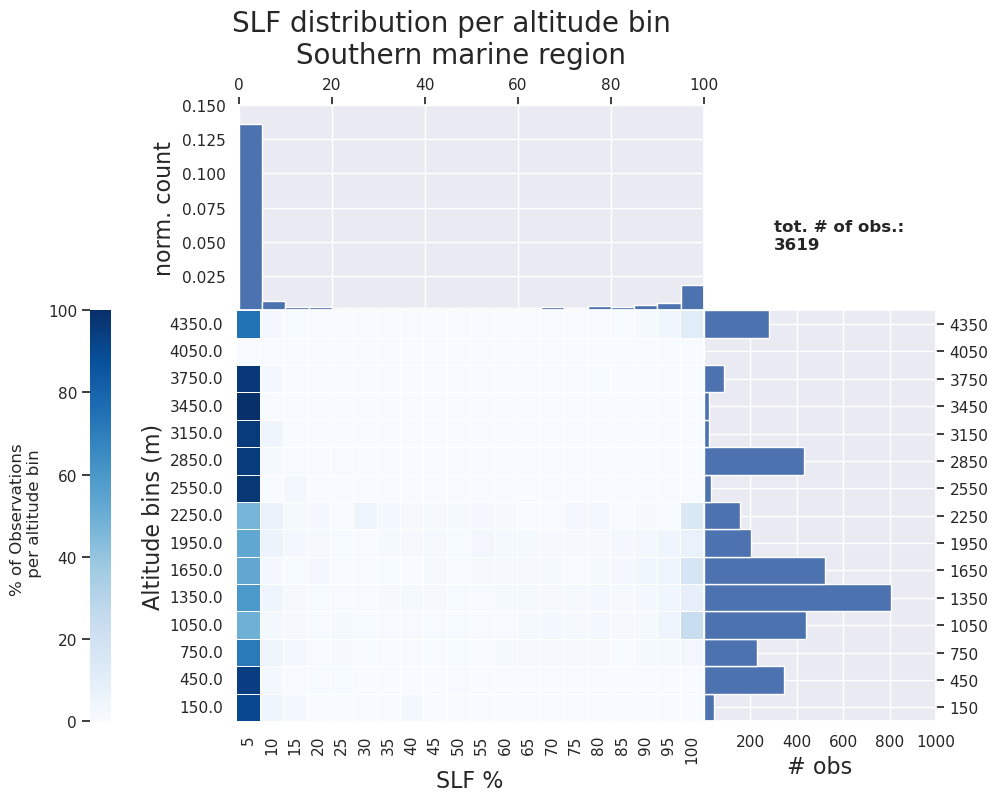

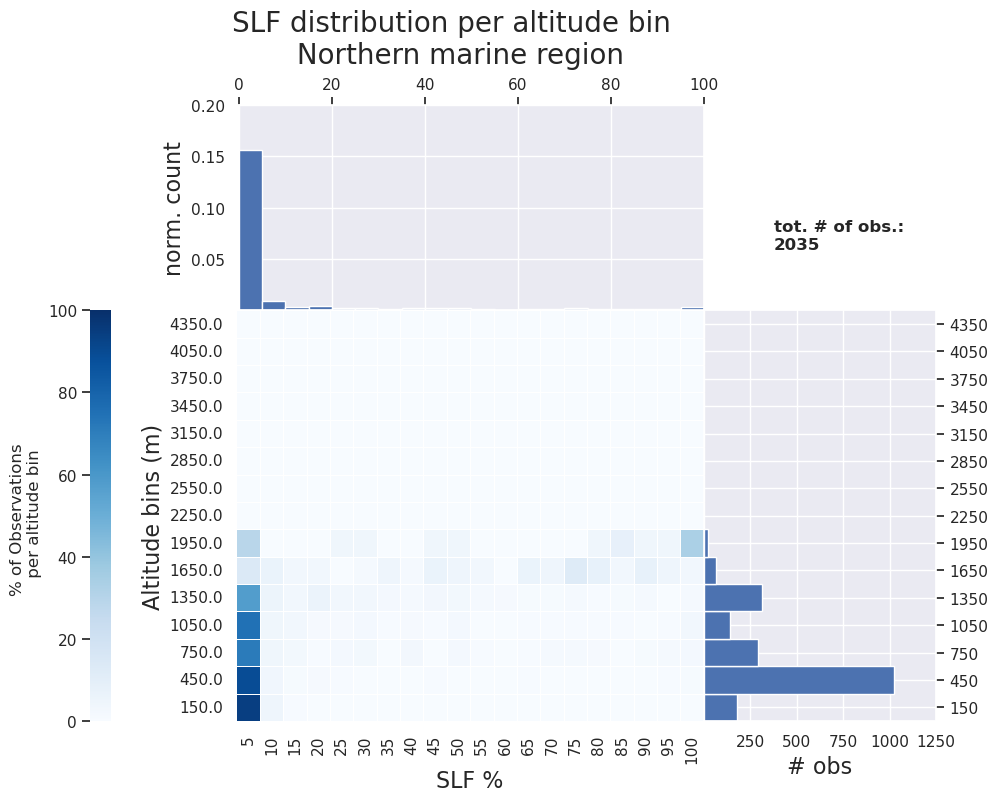

In [49]:
## SINGLE MARGPLOT Testing!!! (code that works)
def slf_marg_plot_alt(df, title, altitude_bins,bin_labels, x_bins=20, y_bins=None, x_range=[0, 100]):
    import matplotlib.gridspec as gridspec
    
    if y_bins is None:
        y_bins = len(altitude_bins) - 1  # number of bins, altitude bins contains edges
    
    # Prepare altitude bin edges based on altitude_bins
    if len(altitude_bins) < 2:
        raise ValueError("altitude_bins must contain at least two edges.")

    # preparing for histogram and 2d histogram
    alt_bin = df['altitude_bin'].values
    slf = df['SLF'].values

    # create a count_df for heatmap plot
    count_df = create_counts_slf(df, bin_labels)
   
    fig = plt.figure(figsize=(12,8))
    
    gs = gridspec.GridSpec(3, 4, wspace = 0, hspace = 0)
    ax_main = plt.subplot(gs[1:3, 0:3])
    ax_xDist = plt.subplot(gs[0, 1:3])#,sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 3])#,sharey=ax_main)
    ax_text = plt.subplot(gs[0,3])
    ax_text.axis('off')
    plots.letter_annotation(ax_text, 0.3, 0.3, f'tot. # of obs.: \n{len(df)}')

    hh = sns.heatmap(count_df, cmap='Blues', ax=ax_main, 
            cbar_kws={"label": "% of Observations \n per altitude bin","location":"left","pad":0.18}, vmin=0, vmax=100,
            linewidths=0.5)
    
    ax_main.set_ylabel('Altitude bins (m)', fontsize = 16)
    ax_main.set_xlabel('SLF %', fontsize = 16)

    # Marginal histograms
    ax_xDist.hist(slf, bins=x_bins, density=True)
    ax_xDist.set_ylabel('norm. count', fontsize = 16)
    ax_xDist.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax_xDist.set_xlim(0,100)
    ax_xDist.set_yticks([tick for tick in ax_xDist.get_yticks() if tick != 0])

    ax_yDist.hist(alt_bin, bins=altitude_bins, orientation='horizontal', density=False)  # Use edges for altitude
    ax_yDist.set_xlabel('# obs', fontsize = 16)
    ax_yDist.yaxis.tick_right()
    ax_yDist.set_ylim(0,4500)
    ax_yDist.set_yticks(bin_labels)
    ax_yDist.set_xticks([tick for tick in ax_yDist.get_xticks() if tick != 0])
    
    plt.suptitle(title, fontsize = 20, y=1)
    #plt.show
    return(fig)


s_plot = slf_marg_plot_alt(south_df, f'SLF distribution per altitude bin \n Southern marine region', altitude_bins, bin_labels)
s_plot.savefig(save_path+f'{th_method}/SLF_alt_South{th_method}{preopt}.png') # Save to
n_plot = slf_marg_plot_alt(north_df, f'SLF distribution per altitude bin \n Northern marine region', altitude_bins, bin_labels)
n_plot.savefig(save_path+f'{th_method}/SLF_alt_North{th_method}{preopt}.png') # Save to

In [42]:
north_top_ds
#north_bulk_ds
north_ds

<xarray.Dataset> Size: 3MB
Dimensions:                 (time: 728, Vector64: 64, Vector40: 40, CDP_Bin: 30)
Coordinates:
  * time                    (time) datetime64[ns] 6kB 2022-03-24T10:46:24 ......
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    lat                     (time) float32 3kB 76.63 76.65 76.66 ... 75.01 75.0
    lon                     (time) float32 3kB 10.95 10.94 10.94 ... 20.89 20.89
    alt                     (time) float32 3kB 1.873e+03 1.725e+03 ... 406.3
    altitude_bin            (time) int64 6kB 1950 1650 1650 1650 ... 450 450 450
Dimensions without coordinates: Vector64, Vector40
Data variables: (12/80)
    base_time               (time) datetime64[ns] 6kB 2022-03-24T08:04:25 ......
    utc_time                (time) float64 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    TAS                     (time) float32 3kB dask.array<chunksize=(728,), meta=np.ndarray>
    MIDBINS                 (time, Vector64) float32 186kB dask.array<chunksize=(728, 64), meta=np.ndarray>
    ACTIVETIME              (time) float32 3kB dask.array<chunksize=(728,), meta=np.ndarray>
    SA                      (time, Vector64) float32 186kB dask.array<chunksize=(728, 64), meta=np.ndarray>
    ...                      ...
    surface_cond            (time) object 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    in_cloud_lwc            (time) float64 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    in_cloud_twc            (time) float64 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    in_cloud                (time) float64 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    Relevance               (time) object 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    region                  (time) object 6kB 'north' 'north' ... 'north'
Attributes:
    date_modified:              2025-04-04
    Joint dataset sample rate:  5.0
    CDP sample area:            0.269
    CDP sample area unit:       mm²
    incloud_thres:              0.01

In [92]:
# Histplots for the top layer of the north and the south
fig, ax = plt.subplots(1, 1, figsize=(10, 8), layout="constrained", sharey=True)
    

ax.hist(midbins[3:], weights=weights[3:], bins=midbins[3:], label="mean area ratio", color='grey', histtype='stepfilled', alpha=0.3)# Plot first three bins in grey
#ax.hist(midbins[3:], weights=min_arear[3:], bins=midbins[3:], label="CIP", histtype='stepfilled', alpha = 0.5)
ax.plot(midbins[3:], weights[3:], label = 'test')


# set labels, titles and legends for subplots
ax.set_ylabel(ds_incloud['MEAN_AREARATIO'].attrs['long_name'])
ax.set_xlabel('Size ($\mu$m)')
#ax.set_title(cat_text)
ax.legend(loc='upper right')

# --- Subplot settings
ax.grid(True)
ax.yaxis.set_tick_params(which='both', labelleft=True)
ax.xaxis.set_tick_params(which='both', labelbottom=True)

# --- Figure 
#plt.suptitle(f'Nort \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}') # title
#plt.savefig(save_path+f'{th_method}/Nt_Latitude_bands_{th_method}{preopt}.png') # Save to
plt.show()


In [ ]:
# Calculate mean SLF per altitude bin (assuming bins are sorted)
mean_slf = df.groupby('altitude_bin')['SLF'].mean().values  # mean SLF values pr altitude bin
mean_slf = pd.Series(mean_slf) # turn into panda series for reindexing
mean_slf = mean_slf.reindex(bin_labels, fill_value=0) #make sure all possible altitude bins are represented, fill with 0
# Plotting the mean SLF as a line
ax_main.plot(bin_labels, mean_slf, color='red', linewidth=2, label='Mean SLF', marker='



In [52]:
north_ds

<xarray.Dataset> Size: 3MB
Dimensions:                 (time: 728, Vector64: 64, Vector40: 40, CDP_Bin: 30)
Coordinates:
  * time                    (time) datetime64[ns] 6kB 2022-03-24T10:46:24 ......
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    lat                     (time) float32 3kB 76.63 76.65 76.66 ... 75.01 75.0
    lon                     (time) float32 3kB 10.95 10.94 10.94 ... 20.89 20.89
    alt                     (time) float32 3kB 1.873e+03 1.725e+03 ... 406.3
    altitude_bin            (time) int64 6kB 1950 1650 1650 1650 ... 450 450 450
Dimensions without coordinates: Vector64, Vector40
Data variables: (12/80)
    base_time               (time) datetime64[ns] 6kB 2022-03-24T08:04:25 ......
    utc_time                (time) float64 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    TAS                     (time) float32 3kB dask.array<chunksize=(728,), meta=np.ndarray>
    MIDBINS                 (time, Vector64) float32 186kB dask.array<chunksize=(728, 64), meta=np.ndarray>
    ACTIVETIME              (time) float32 3kB dask.array<chunksize=(728,), meta=np.ndarray>
    SA                      (time, Vector64) float32 186kB dask.array<chunksize=(728, 64), meta=np.ndarray>
    ...                      ...
    surface_cond            (time) object 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    in_cloud_lwc            (time) float64 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    in_cloud_twc            (time) float64 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    in_cloud                (time) float64 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    Relevance               (time) object 6kB dask.array<chunksize=(728,), meta=np.ndarray>
    region                  (time) object 6kB 'north' 'north' ... 'north'
Attributes:
    date_modified:              2025-04-04
    Joint dataset sample rate:  5.0
    CDP sample area:            0.269
    CDP sample area unit:       mm²
    incloud_thres:              0.01

In [104]:
# Create dataframe for visualizing available observations with Heatmap
north_df

time        SLF  altitude_bin       SLF_bins
0   2022-03-24 10:46:24  92.885555          1950   (90.0, 95.0]
1   2022-03-24 10:46:49  15.219889          1650   (15.0, 20.0]
2   2022-03-24 10:46:59  85.541884          1650   (85.0, 90.0]
3   2022-03-24 10:47:04  62.419927          1650   (60.0, 65.0]
4   2022-03-24 10:47:09   7.407537          1650    (5.0, 10.0]
..                  ...        ...           ...            ...
723 2022-04-03 14:54:34  93.234530           450   (90.0, 95.0]
724 2022-04-03 14:55:19  86.430664           450   (85.0, 90.0]
725 2022-04-03 14:55:24  74.334156           450   (70.0, 75.0]
726 2022-04-03 14:55:29  97.615749           450  (95.0, 100.0]
727 2022-04-03 14:55:34  99.729196           450  (95.0, 100.0]

[728 rows x 4 columns]

Text(78.75, 0.5, 'Altitude Bins (300 m)')

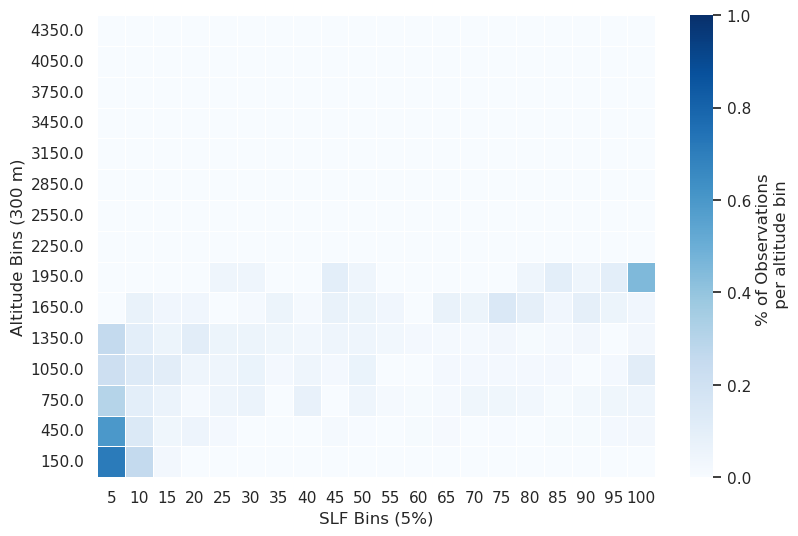

In [109]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(ncount_df, cmap='Blues', ax=ax, 
            cbar_kws={"label": "% of Observations \n per altitude bin"}, vmin=0, vmax=1,
            linewidths=0.5)

plt.xlabel('SLF Bins (%)')
plt.ylabel('Altitude Bins (m)')


SLF_bins      (-0.001, 5.0]  (5.0, 10.0]  (10.0, 15.0]  (15.0, 20.0]  \
altitude_bin                                                           
4350.0             0.000000     0.000000      0.000000      0.000000   
4050.0             0.000000     0.000000      0.000000      0.000000   
3750.0             0.000000     0.000000      0.000000      0.000000   
3450.0             0.000000     0.000000      0.000000      0.000000   
3150.0             0.000000     0.000000      0.000000      0.000000   
2850.0             0.000000     0.000000      0.000000      0.000000   
2550.0             0.000000     0.000000      0.000000      0.000000   
2250.0             0.000000     0.000000      0.000000      0.000000   
1950.0             0.000000     0.000000      0.000000      0.000000   
1650.0             0.000000     0.076923      0.038462      0.038462   
1350.0             0.264368     0.103448      0.057471      0.109195   
1050.0             0.243902     0.146341      0.121951      0.048780   
750.0              0.318584     0.106195      0.061947      0.017699   
450.0              0.614232     0.146067      0.041199      0.052434   
150.0              0.714286     0.257143      0.028571      0.000000   

SLF_bins      (20.0, 25.0]  (25.0, 30.0]  (30.0, 35.0]  (35.0, 40.0]  \
altitude_bin                                                           
4350.0            0.000000      0.000000      0.000000      0.000000   
4050.0            0.000000      0.000000      0.000000      0.000000   
3750.0            0.000000      0.000000      0.000000      0.000000   
3450.0            0.000000      0.000000      0.000000      0.000000   
3150.0            0.000000      0.000000      0.000000      0.000000   
2850.0            0.000000      0.000000      0.000000      0.000000   
2550.0            0.000000      0.000000      0.000000      0.000000   
2250.0            0.000000      0.000000      0.000000      0.000000   
1950.0            0.090909      0.090909      0.000000      0.000000   
1650.0            0.000000      0.019231      0.057692      0.019231   
1350.0            0.057471      0.057471      0.040230      0.034483   
1050.0            0.048780      0.073171      0.024390      0.048780   
750.0             0.053097      0.061947      0.000000      0.079646   
450.0             0.022472      0.003745      0.003745      0.003745   
150.0             0.000000      0.000000      0.000000      0.000000   

SLF_bins      (40.0, 45.0]  (45.0, 50.0]  (50.0, 55.0]  (55.0, 60.0]  \
altitude_bin                                                           
4350.0            0.000000      0.000000      0.000000      0.000000   
4050.0            0.000000      0.000000      0.000000      0.000000   
3750.0            0.000000      0.000000      0.000000      0.000000   
3450.0            0.000000      0.000000      0.000000      0.000000   
3150.0            0.000000      0.000000      0.000000      0.000000   
2850.0            0.000000      0.000000      0.000000      0.000000   
2550.0            0.000000      0.000000      0.000000      0.000000   
2250.0            0.000000      0.000000      0.000000      0.000000   
1950.0            0.181818      0.090909      0.000000      0.000000   
1650.0            0.076923      0.057692      0.038462      0.000000   
1350.0            0.051724      0.045977      0.034483      0.022989   
1050.0            0.024390      0.073171      0.000000      0.000000   
750.0             0.000000      0.053097      0.017699      0.008850   
450.0             0.018727      0.007491      0.003745      0.011236   
150.0             0.000000      0.000000      0.000000      0.000000   

SLF_bins      (60.0, 65.0]  (65.0, 70.0]  (70.0, 75.0]  (75.0, 80.0]  \
altitude_bin                                                           
4350.0            0.000000      0.000000      0.000000      0.000000   
4050.0            0.000000      0.000000      0.000000      0.000000   
3750.0            0.000000      0.000